# Home Credit Default Risk - EDA TRAIN / TEST

## 1. Introduction

**1. Context:**

Home Credit strives to broaden financial inclusion for the unbanked population by providing safe and positive borrowing experiences.  
To achieve this, the company leverages a variety of alternative data sources — including telco and transactional information — to predict repayment ability and reduce default risk.

**This notebook** focuses on the **main application dataset**:

    - `application_train.csv` - training data, includes target (`TARGET`)
    - `application_test.csv` - test data, no target
    - Each row = one loan application, with static applicant-level information.

**2. Goals:**

    - Gain an initial understanding of the dataset’s structure, distributions, and quality.  
    - Identify issues that may affect downstream modeling (missingness, outliers, anomalies).  
    - Explore relationships between features and the target to generate hypotheses for feature engineering.  
    - Create summary visuals and reports (manual + automated tools like **Sweetviz**) to speed up insights.

**3. Objectives:**

    1. Comprehensive EDA – describe variables, distributions, and dataset properties.  
    2. Data quality check – investigate missing values, anomalies, inconsistencies.  
    3. Feature–target analysis – assess correlations and separations between features and default outcome.  
    4. Automated profiling – leverage tools such as *Sweetviz* for an initial feature overview.  

**Key takeaway for this notebook**: build a strong understanding of the raw data, which will directly guide **feature engineering** and **modeling strategy** in subsequent steps.

## 2. Exploratory Data Analysis (EDA)

### A. Data loading & Initial overview

In [2]:
%load_ext jupyter_black

In [3]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu
from typing import Dict, Optional, List, Tuple, Union
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
from pandas.errors import PerformanceWarning
import missingno as msno
import warnings
from phik import report

warnings.simplefilter(action="ignore", category=PerformanceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sweetviz.graph")
import sweetviz as sv
from ydata_profiling import ProfileReport
from IPython.display import IFrame

In [4]:
sys.path.append(os.path.abspath(".."))
from Data.utils_EDA import (
    feature_types,
    missing_columns,
    calculate_missing_rows,
    plot_target_distribution,
    classify_features,
    handle_rare_categories,
    create_missing_flags,
    collapse_building_flags,
    impute_missing_values,
    plot_distribution_numerical,
    stacked_bar_with_percent,
    handle_anomalies,
)
from Data.utils_modeling import (
    downcast_numeric_col,
    handle_date_anom_1000,
    handle_date_anom_50,
    convert_days_to_years,
)

**Loading datasets**

In [7]:
df_train = pd.read_csv(r"../Data/application_train.csv")
df_train.shape

(307511, 122)

In [8]:
df_test = pd.read_csv(r"../Data/application_test.csv")
df_test.shape

(48744, 121)

In [7]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


**Downcasting numeric columns**

In [6]:
train = df_train.copy()
downcast_numeric_col(train)
train.dtypes.unique()

array([dtype('int32'), dtype('int8'), dtype('O'), dtype('float64'),
       dtype('float32'), dtype('int16')], dtype=object)

In [7]:
test = df_test.copy()
downcast_numeric_col(test)
test.dtypes.unique()

array([dtype('int32'), dtype('O'), dtype('int8'), dtype('float64'),
       dtype('float32'), dtype('int16')], dtype=object)

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float32(64), float64(1), int16(2), int32(2), int8(37), object(16)
memory usage: 129.3+ MB


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float32(64), float64(1), int16(2), int32(2), int8(36), object(16)
memory usage: 20.5+ MB


**Checking for duplicates.**

In [13]:
print(
    f"Duplicates: {train.duplicated().sum()}, {(train.duplicated().sum() / len(train) * 100):.2f}%"
)

Duplicates: 0, 0.00%


In [14]:
print(
    f"Duplicates: {test.duplicated().sum()}, {(test.duplicated().sum() / len(test) * 100):.2f}%"
)

Duplicates: 0, 0.00%


    There ar eno duplicates in train or test datasets.

**Feature descriptions:**

There are 122 (121) features in train (test) data set. All feature descriptions can be found in **Data\HomeCredit_columns_description.csv** file.
In this notebook I will use descriptions only for analyzed features.

**Feature types**

In [15]:
feature_types(train)

Numerical features: ['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLU

In [16]:
feature_types(test)

Numerical features: ['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MO

In [17]:
train.dtypes.value_counts()

float32    64
int8       37
object     16
int32       2
int16       2
float64     1
Name: count, dtype: int64

In [18]:
test.dtypes.value_counts()

float32    64
int8       36
object     16
int32       2
int16       2
float64     1
Name: count, dtype: int64

We see only difference in int8 data type, probably it is TARGET feature 0/1 values.

### B. Checking target variable (TARGET)

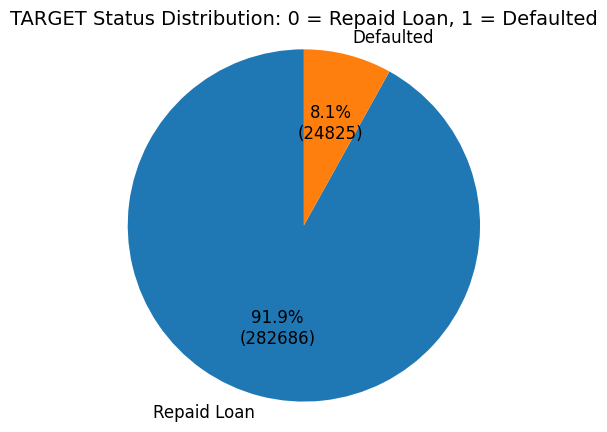

In [19]:
plot_target_distribution(train)

**Handling Class Imbalance**

The distribution of our target variable is highly imbalanced, with only 8.1% of clients defaulting on their loans compared to 91.9% who do not. This significant disparity can bias our model towards the majority class.

To address this challenge and ensure our model effectively learns to identify the minority class (defaulters), we will implement two key strategies:

    Stratified Sampling: We will use the stratify option during data splitting to ensure both our training and validation sets maintain the same proportion of target classes as the original dataset.

    Class Weighting: We will apply a class_weight parameter in our modeling, which adjusts the penalty for misclassifying the minority class. This technique helps the model pay more attention to the rare instances of default.

### C. Train vs Test datasets comparison

**General differences, common columns**

In [20]:
train = train.copy()
test = test.copy()
print(f"train shape: {train.shape}, test shape: {test.shape}")

train_cols = set(train.columns)
test_cols = set(test.columns)

only_in_train = sorted(list(train_cols - test_cols))
only_in_test = sorted(list(test_cols - train_cols))
common_cols = sorted(list(train_cols & test_cols))

print("\nColumns present only in TRAIN (not in test):")
print(only_in_train[:50] if only_in_train else "(none)")

print("\nColumns present only in TEST (not in train):")
print(only_in_test[:50] if only_in_test else "(none)")

print(f"\nCommon columns (count): {len(common_cols)}")

train shape: (307511, 122), test shape: (48744, 121)

Columns present only in TRAIN (not in test):
['TARGET']

Columns present only in TEST (not in train):
(none)

Common columns (count): 121


**Numerical and categorical columns**

In [21]:
num_train_cols = train.select_dtypes(include=[np.number]).columns.tolist()
num_test_cols = test.select_dtypes(include=[np.number]).columns.tolist()
cat_train_cols = train.select_dtypes(exclude=[np.number]).columns.tolist()
cat_test_cols = test.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_common = [c for c in sorted(set(num_train_cols) & set(num_test_cols))]
print(f"\nNumeric columns common to train & test: {len(numeric_common)}")

categorical_common = [c for c in sorted(set(cat_train_cols) & set(cat_test_cols))]
print(f"\nCategorical columns common to train & test: {len(categorical_common)}")


Numeric columns common to train & test: 105

Categorical columns common to train & test: 16


Numerical and categorical columns match train and test datasets.

**Comparing the cardinality of categorical columns**

In [22]:
cat_common = sorted(list(set(cat_train_cols) & set(cat_test_cols)))
cat_diff_card = []
for c in cat_common:
    n_train = train[c].nunique(dropna=False)
    n_test = test[c].nunique(dropna=False)
    if n_train != n_test:
        cat_diff_card.append((c, n_train, n_test))
print(
    f"\nCategorical columns with differing cardinality between train/test (sample): {cat_diff_card[:20]}"
)


Categorical columns with differing cardinality between train/test (sample): [('CODE_GENDER', 3, 2), ('NAME_FAMILY_STATUS', 6, 5), ('NAME_INCOME_TYPE', 8, 7)]


**Checking for difference in cardinality**

In [23]:
for col in ["CODE_GENDER", "NAME_FAMILY_STATUS", "NAME_INCOME_TYPE"]:
    print(col, set(train[col].unique()) - set(test[col].unique()))

CODE_GENDER {'XNA'}
NAME_FAMILY_STATUS {'Unknown'}
NAME_INCOME_TYPE {'Maternity leave'}


In [24]:
train["CODE_GENDER"].value_counts()

CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64

In [25]:
train["NAME_FAMILY_STATUS"].value_counts()

NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64

In [26]:
train["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64

**Replacing rare categories**

    CODE_GENDER {'XNA'}
    
    NAME_FAMILY_STATUS {'Unknown'}
    
    NAME_INCOME_TYPE {'Maternity leave'}

This categories from train set from above columns, which don't exist in test set we will **replace with "Other" category**, to keep the model robust to rare/unseen categories, function (handle_rare_categories).

In [8]:
train = handle_rare_categories(train)
test = handle_rare_categories(test)
train["NAME_INCOME_TYPE"].value_counts()

NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Other                        5
Name: count, dtype: int64

### D. Data Types

To prepare our data for modeling, or phi-k correlation we will classify features into five distinct categories based on data type and cardinality:

    Continuous Numeric: Features with more than 20 unique values.

    Discrete Numeric: Features with 20 or fewer unique values.

    Low-Cardinality Categorical: Categorical features with 10 or fewer unique values.

    Medium/High-Cardinality Categorical: Categorical features with more than 10 unique values.

    Date: Datetime features.

This structured approach ensures each feature is handled with the appropriate preprocessing method, like different imputation or encoding strategies.

In [28]:
summary = classify_features(train, target_col="TARGET")
print(summary.groupby("classification").size())

classification
continuous_numeric                     58
date                                    5
discrete_numeric                       42
low_cardinality_categorical            14
medium_high_cardinality_categorical     2
dtype: int64


In [29]:
summary = classify_features(test, target_col="TARGET")
print(summary.groupby("classification").size())

classification
continuous_numeric                     56
date                                    5
discrete_numeric                       44
low_cardinality_categorical            14
medium_high_cardinality_categorical     2
dtype: int64


The observation that some features are classified as continuous numeric in the training set but as discrete numeric in the test set is likely because their number of unique values in the test set fell below the threshold of 20. This indicates that the distributions of these two datasets are not perfectly identical.

### E. Missing values

Train data set Missing cells 24.4% (Ydata report)

**Percentage of rows with missing values**

In [30]:
calculate_missing_rows(train)

Missing rows: 298909 of 307511 total rows in data set.
Missing rows %: 97.20


In [31]:
calculate_missing_rows(test)

Missing rows: 47005 of 48744 total rows in data set.
Missing rows %: 96.43


    Almost all row in train and test datasets contains missing values

**Percentage of missing values for each column.**

In [32]:
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
missing_columns(train)

,Missing Count,Missing Count Ratio,Missing Count %
COMMONAREA_MEDI,214865,0.698723,69.9
COMMONAREA_AVG,214865,0.698723,69.9
COMMONAREA_MODE,214865,0.698723,69.9
NONLIVINGAPARTMENTS_MODE,213514,0.694330,69.4
NONLIVINGAPARTMENTS_AVG,213514,0.694330,69.4
NONLIVINGAPARTMENTS_MEDI,213514,0.694330,69.4
FONDKAPREMONT_MODE,210295,0.683862,68.4
LIVINGAPARTMENTS_MODE,210199,0.683550,68.4
LIVINGAPARTMENTS_AVG,210199,0.683550,68.4
LIVINGAPARTMENTS_MEDI,210199,0.683550,68.4


In [33]:
missing_columns(test)

,Missing Count,Missing Count Ratio,Missing Count %
COMMONAREA_AVG,33495,0.687161,68.7
COMMONAREA_MODE,33495,0.687161,68.7
COMMONAREA_MEDI,33495,0.687161,68.7
NONLIVINGAPARTMENTS_AVG,33347,0.684125,68.4
NONLIVINGAPARTMENTS_MODE,33347,0.684125,68.4
NONLIVINGAPARTMENTS_MEDI,33347,0.684125,68.4
FONDKAPREMONT_MODE,32797,0.672842,67.3
LIVINGAPARTMENTS_AVG,32780,0.672493,67.2
LIVINGAPARTMENTS_MODE,32780,0.672493,67.2
LIVINGAPARTMENTS_MEDI,32780,0.672493,67.2


There are a lot of features with missing more than 50% of values. The columns with most missing values looks similar, example:
    
    COMMONAREA_MEDI0, COMMONAREA_AVG, COMMONAREA_MODE

We need to investigate columns with missing values correlations.

**Visualize patterns of missingness**

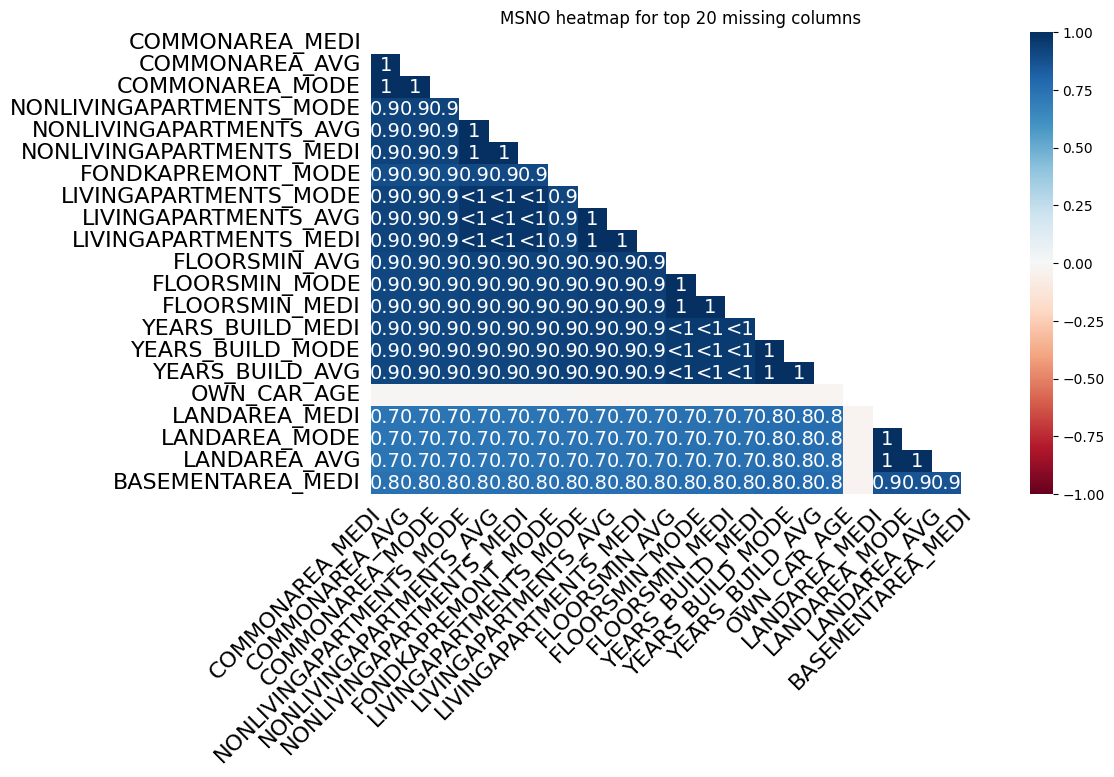

In [34]:
missing_pct = train.isna().mean().sort_values(ascending=False)

top_missing = missing_pct.head(21).index
msno.heatmap(train[top_missing], figsize=(10, 6))
plt.title(f"MSNO heatmap for top 20 missing columns")
plt.show()

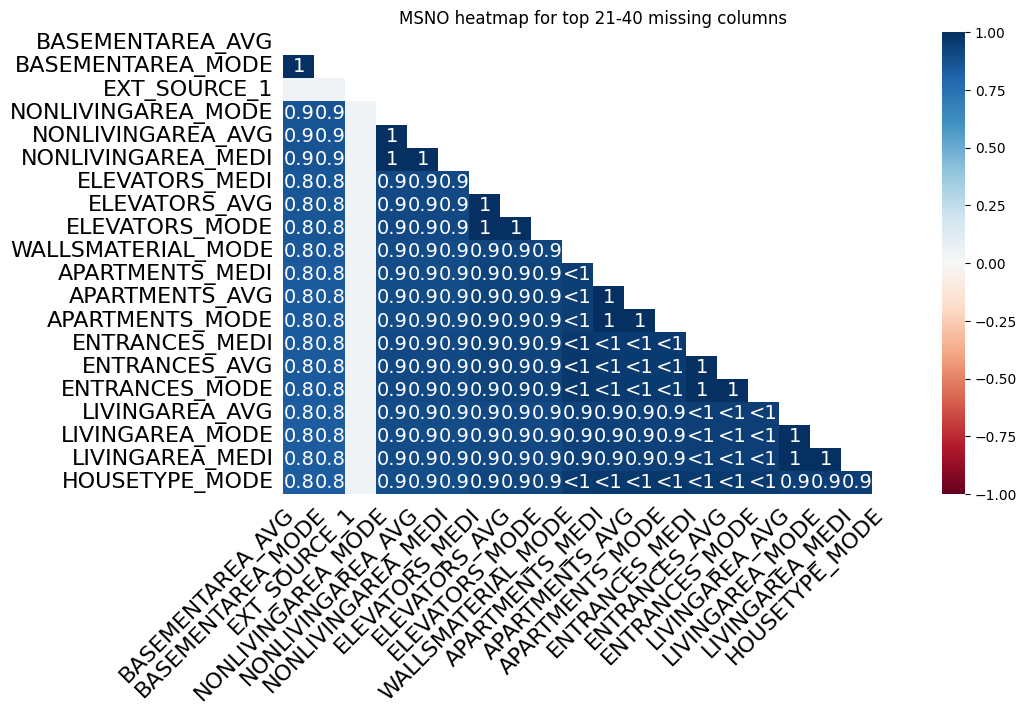

In [35]:
top2_missing = missing_pct.iloc[21:41].index

msno.heatmap(train[top2_missing], figsize=(10, 6))
plt.title(f"MSNO heatmap for top 21-40 missing columns")
plt.show()

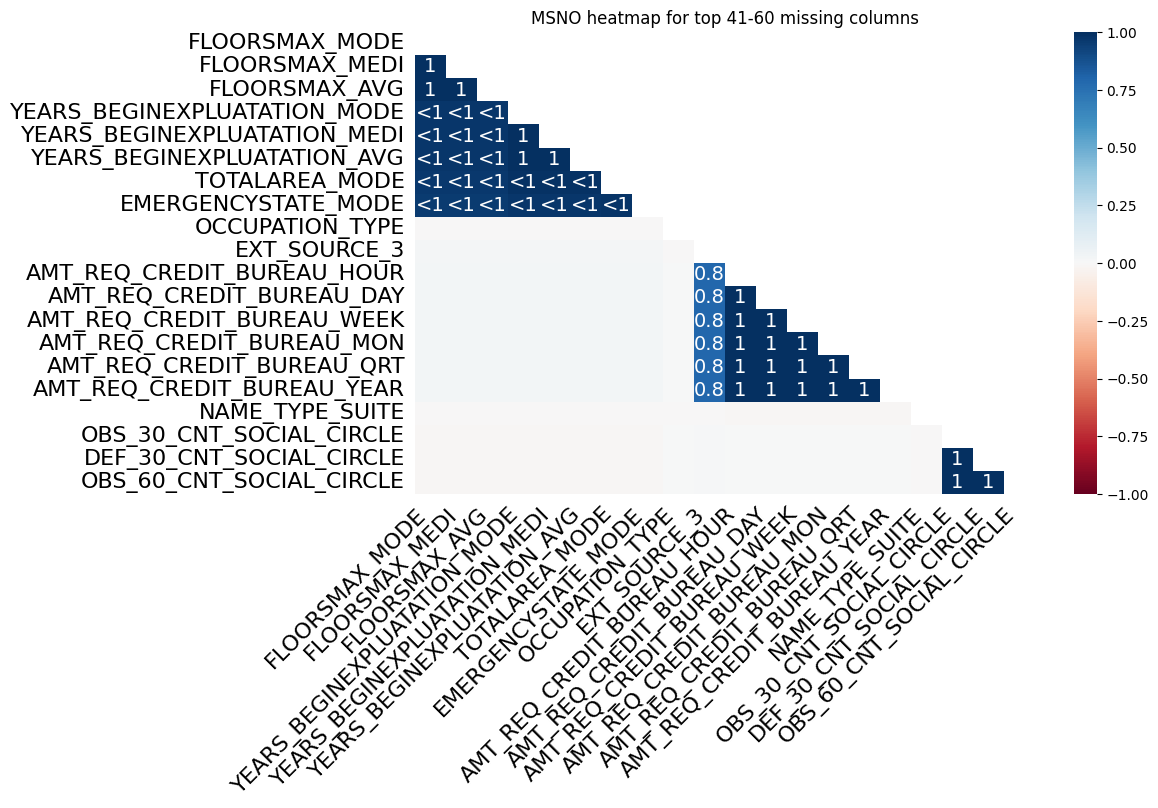

In [36]:
top3_missing = missing_pct.iloc[41:61].index
msno.heatmap(train[top3_missing], figsize=(10, 6))
plt.title(f"MSNO heatmap for top 41-60 missing columns")
plt.show()

The msno heatmap revealed that several groups of features have a high correlation in their missing values (from 0.7 to above 0.9). This strong dependency indicates that these features do not provide an independent signal when missing, as a missing value in one almost always corresponds to a missing value in the others.

To reduce multicollinearity and simplify the dataset, we will retain only the _AVG representation of these feature groups and drop the redundant _MEDI and _MODE columns.

Other features with missing values will be left.

    create_missing_flags function:

We will create missing flags for _AVG representations.

Columns EXT_SOURCE_1, OCCUPATION_TYPE, are very important and don't have correlations, we will create missing flag for these columns.

In [36]:
redundant_groups = [
    ["COMMONAREA_AVG", "COMMONAREA_MEDI", "COMMONAREA_MODE"],
    ["NONLIVINGAPARTMENTS_AVG", "NONLIVINGAPARTMENTS_MEDI", "NONLIVINGAPARTMENTS_MODE"],
    ["LIVINGAPARTMENTS_AVG", "LIVINGAPARTMENTS_MEDI", "LIVINGAPARTMENTS_MODE"],
    ["YEARS_BUILD_AVG", "YEARS_BUILD_MEDI", "YEARS_BUILD_MODE"],
    ["LANDAREA_AVG", "LANDAREA_MEDI", "LANDAREA_MODE"],
    ["BASEMENTAREA_AVG", "BASEMENTAREA_MEDI", "BASEMENTAREA_MODE"],
    ["NONLIVINGAREA_AVG", "NONLIVINGAREA_MEDI", "NONLIVINGAREA_MODE"],
    ["ELEVATORS_AVG", "ELEVATORS_MEDI", "ELEVATORS_MODE"],
    ["APARTMENTS_AVG", "APARTMENTS_MEDI", "APARTMENTS_MODE"],
    ["ENTRANCES_AVG", "ENTRANCES_MEDI", "ENTRANCES_MODE"],
    ["LIVINGAREA_AVG", "LIVINGAREA_MEDI", "LIVINGAREA_MODE"],
    ["FLOORSMAX_AVG", "FLOORSMAX_MEDI", "FLOORSMAX_MODE"],
    ["FLOORSMIN_AVG", "FLOORSMIN_MEDI", "FLOORSMIN_MODE"],
    [
        "YEARS_BEGINEXPLUATATION_AVG",
        "YEARS_BEGINEXPLUATATION_MEDI",
        "YEARS_BEGINEXPLUATATION_MODE",
    ],
]

In [37]:
train.shape

(307511, 122)

In [9]:
train = create_missing_flags(train)
test = create_missing_flags(test)
train.shape

(307511, 110)

In [39]:
print([col for col in train.columns if col.endswith("_MISSING")])

['EXT_SOURCE_1_MISSING', 'OCCUPATION_TYPE_MISSING', 'COMMONAREA_AVG_MISSING', 'NONLIVINGAPARTMENTS_AVG_MISSING', 'LIVINGAPARTMENTS_AVG_MISSING', 'YEARS_BUILD_AVG_MISSING', 'LANDAREA_AVG_MISSING', 'BASEMENTAREA_AVG_MISSING', 'NONLIVINGAREA_AVG_MISSING', 'ELEVATORS_AVG_MISSING', 'APARTMENTS_AVG_MISSING', 'ENTRANCES_AVG_MISSING', 'LIVINGAREA_AVG_MISSING', 'FLOORSMAX_AVG_MISSING', 'FLOORSMIN_AVG_MISSING', 'YEARS_BEGINEXPLUATATION_AVG_MISSING']


The analysis of missing values reveals a strong pattern: clients who fail to provide information for one building-related feature are highly likely to omit data for others as well. 

To avoid multicollinearity and simplify the model, we will collapse the 12 individual building-related missing flags into two consolidated features:

    an ANY flag (indicating if at least one building feature is missing) / BUILDING_INFO_ANY_MISSING 
    and a COUNT feature (indicating the total number of missing building features) / BUILDING_INFO_MISSING_COUNT

The original, individual flags will then be dropped from the dataset. This approach effectively captures the underlying information while creating a more streamlined and robust feature set.

In [10]:
train = collapse_building_flags(train)
test = collapse_building_flags(test)
train.shape

(307511, 98)

In [41]:
train["BUILDING_INFO_MISSING_COUNT"].describe()

count    307511.000000
mean          8.182081
std           6.151516
min           0.000000
25%           0.000000
50%          10.000000
75%          14.000000
max          14.000000
Name: BUILDING_INFO_MISSING_COUNT, dtype: float64

**Key Insights (Missing Values & Feature Engineering)**

    For feature groups with high missingness, only the _AVG columns were retained; redundant _MEDI and _MODE columns were dropped.

    Created missing-value flags for: EXT_SOURCE_1, OCCUPATION_TYPE.

Engineered building-related indicators:

    BUILDING_INFO_ANY_MISSING (binary flag)
    
    BUILDING_INFO_MISSING_COUNT (number of missing building attributes)


### F. Univariate and Bivariate analysis

**Sweetviz report**

In [ ]:
report = sv.analyze(train)
html_file = f"Train_sweetviz_report.html"
report.show_html(html_file)
#display(IFrame(html_file, width=950, height=600))

**Ydata report**

In [ ]:
profile = ProfileReport(train, title="Train EDA", explorative=True)

profile.to_file("Train_EDA.html")

**Sweetviz Report & Initial Analysis**

The Sweetviz report provides a comprehensive overview of the dataset, including general statistics and a detailed histogram for every feature. This approach was chosen due to its efficiency, as an equivalent Ydata-profiling report exceeded the file size limit of 360 MB.

**Univariate & Bivariate Analysis**

For a deeper dive into the data, this section will begin by analyzing five key date features.

Following this, **Phik correlation** will be used to identify **the top 25 most impactful features**. These selected features will then undergo a detailed univariate and bivariate analysis to understand their individual distributions and relationships with the target variable.

**Description for numeric columns for raw datasets**

In [42]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,1.000020e+05,189145.500000,278202.000000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
AMT_GOODS_PRICE,307233.0,538396.207429,369446.460540,4.050000e+04,238500.000000,450000.000000,679500.000000,4.050000e+06
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-1.791200e+04,-2760.000000,-1213.000000,-289.000000,3.652430e+05


In [43]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,48744.0,277796.676350,103169.547296,100001.000000,188557.750000,277549.000000,367555.500000,4.562500e+05
CNT_CHILDREN,48744.0,0.397054,0.709047,0.000000,0.000000,0.000000,1.000000,2.000000e+01
AMT_INCOME_TOTAL,48744.0,178431.805855,101522.591536,26941.500000,112500.000000,157500.000000,225000.000000,4.410000e+06
AMT_CREDIT,48744.0,516740.435561,365397.004174,45000.000000,260640.000000,450000.000000,675000.000000,2.245500e+06
AMT_ANNUITY,48720.0,29426.240209,16016.368315,2295.000000,17973.000000,26199.000000,37390.500000,1.805760e+05
AMT_GOODS_PRICE,48744.0,462618.840473,336710.215040,45000.000000,225000.000000,396000.000000,630000.000000,2.245500e+06
REGION_POPULATION_RELATIVE,48744.0,0.021226,0.014428,0.000253,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,48744.0,-16068.084605,4325.900393,-25195.000000,-19637.000000,-15785.000000,-12496.000000,-7.338000e+03
DAYS_EMPLOYED,48744.0,67485.366322,144348.507136,-17463.000000,-2910.000000,-1293.000000,-296.000000,3.652430e+05
DAYS_REGISTRATION,48744.0,-4967.652716,3552.612035,-23722.000000,-7459.250000,-4490.000000,-1901.000000,0.000000e+00


#### Days features

    DAYS_BIRTH - Client's age in days at the time of application,time only relative to the application

In [54]:
train["DAYS_BIRTH"].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

All days features in train/test datasets are negative, so to converting days to years I will use multiplying/dividing -1.

**Converting days to years**

In [56]:
(train["DAYS_BIRTH"] / -365.25).describe()

count    307511.000000
mean         43.906900
std          11.947950
min          20.503765
25%          33.984942
50%          43.121150
75%          53.886379
max          69.073238
Name: DAYS_BIRTH, dtype: float64

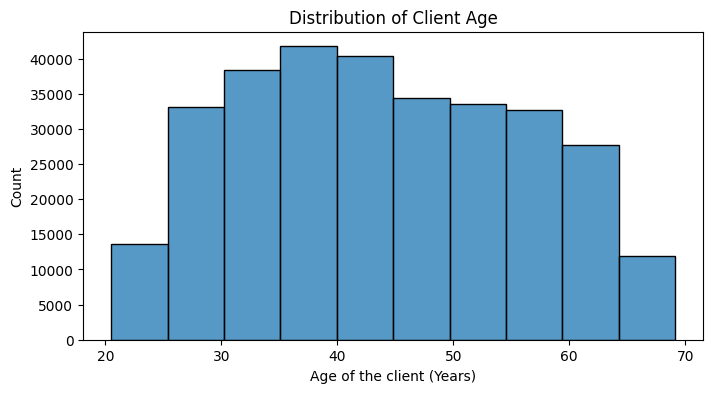

In [59]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(x=train["DAYS_BIRTH"] / -365, bins=10, ax=ax)
ax.set_xlabel("Age of the client (Years)")
ax.set_title("Distribution of Client Age")
plt.show()

The data spans a range from 20.5 to 69 years, with an average age of approximately 43.9 years. The median age is slightly lower at 43.1 years, which, along with the user's observation, confirms the distribution has a slight right skew. This means there is a small number of older clients pulling the average age slightly higher than the median.

The majority of clients are concentrated between 34 and 54 years of age, encompassing the middle 50% of the dataset.

**Test dataset**

In [61]:
(test["DAYS_BIRTH"] / -365.25).describe()

count    48744.000000
mean        43.992018
std         11.843670
min         20.090349
25%         34.212183
50%         43.216975
75%         53.763176
max         68.980151
Name: DAYS_BIRTH, dtype: float64

The statistical distribution of client ages in the test dataset is very similar to that of the training dataset.

    DAYS_EMPLOYED - How many days before the application the person started current employment,time only relative to the application

In [64]:
(train["DAYS_EMPLOYED"] / 365.25).describe()

count    307511.000000
mean        174.716074
std         386.791969
min         -49.040383
25%          -7.556468
50%          -3.321013
75%          -0.791239
max         999.980835
Name: DAYS_EMPLOYED, dtype: float64

The negative values in the DAYS_EMPLOYED feature are expected, as they correctly represent the number of days before the application that a person started their current employment. However, the data contains**significant anomalies**, specifically a group of clients with an employment duration of approximately **1,000 years.**

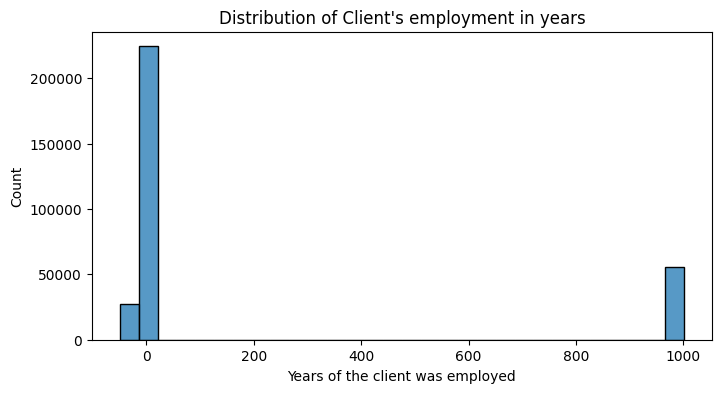

In [65]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(x=train["DAYS_EMPLOYED"] / 365, bins=30, ax=ax)
ax.set_xlabel("Years of the client was employed")
ax.set_title("Distribution of Client's employment in years")
plt.show()

In [66]:
(test["DAYS_EMPLOYED"]).describe()

count     48744.000000
mean      67485.366322
std      144348.507136
min      -17463.000000
25%       -2910.000000
50%       -1293.000000
75%        -296.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

The **test** dataset contains the **same anomalies.**

**Checking number of anomalies**

In [68]:
(train["DAYS_EMPLOYED"] == 365243).sum()

55374

In [69]:
anomalies_employed = train[
    (train["DAYS_EMPLOYED"] / 365 >= 900) & (train["DAYS_EMPLOYED"] / 365 <= 1100)
]
len(anomalies_employed)

55374

**Proportion of DAYS_EMPLOYED anomalies vs TARGET**

In [70]:
anomalies_employed["TARGET"].value_counts(normalize=True)

TARGET
0    0.946004
1    0.053996
Name: proportion, dtype: float64

Proportion for anomalies **5.4%**  differs from general TARGET distribution **8.1%**, I will create flag for anomalies and replace anomalies with NaN.

In [11]:
train = handle_date_anom_1000(train, ["DAYS_EMPLOYED"])
test = handle_date_anom_1000(test, ["DAYS_EMPLOYED"])
train["DAYS_EMPLOYED"].describe()

count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64

**Histogram of years employed without anomalies**

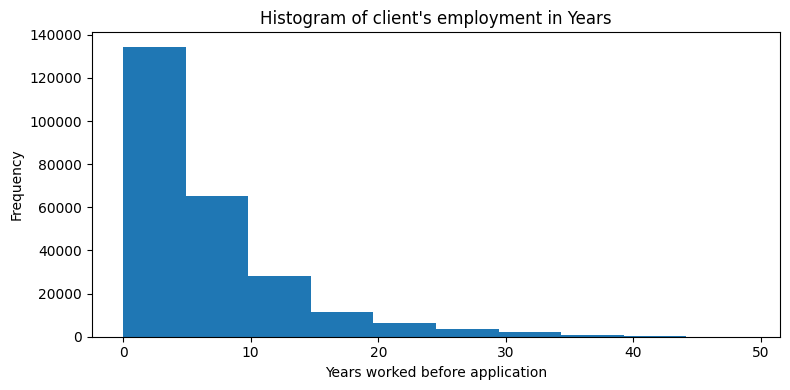

In [48]:
plt.figure(figsize=(8, 4))
(train["DAYS_EMPLOYED"] / -365.25).plot.hist(
    title="Histogram of client's employment in Years"
)
plt.xlabel("Years worked before application")
plt.tight_layout()
plt.show()

After removing anomalies, the histogram of YEARS_EMPLOYED **appears to be valid.**

    DAYS_REGISTRATION - How many days before the application did client change his registration,time only relative to the application

In [50]:
(train["DAYS_REGISTRATION"] / -365.25).describe()

count    307511.000000
mean         13.651255
std           9.645137
min          -0.000000
25%           5.503080
50%          12.331280
75%          20.477755
max          67.548256
Name: DAYS_REGISTRATION, dtype: float64

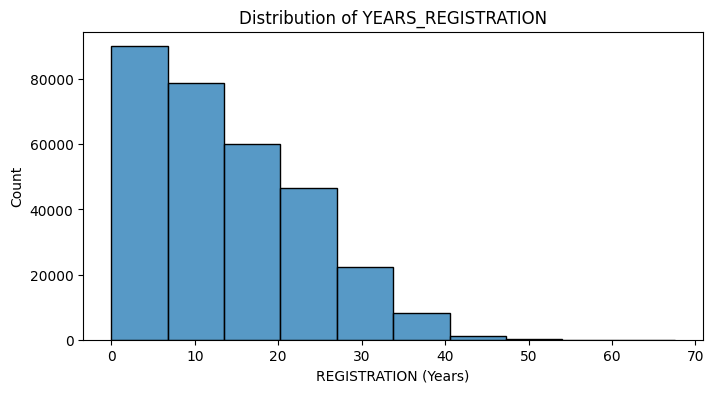

In [51]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(x=train["DAYS_REGISTRATION"] / -365.25, bins=10, ax=ax)
ax.set_xlabel("REGISTRATION (Years)")
ax.set_title("Distribution of YEARS_REGISTRATION")
plt.show()

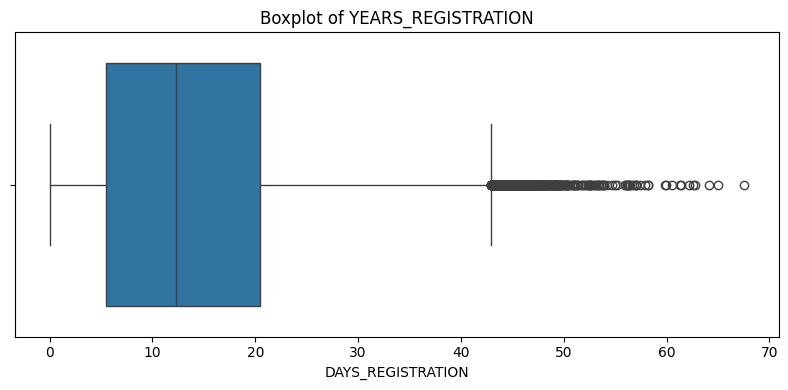

In [52]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x=train["DAYS_REGISTRATION"] / -365.25)
ax.set_title("Boxplot of YEARS_REGISTRATION")
plt.tight_layout()
plt.show()

In [54]:
(test["DAYS_REGISTRATION"] / -365.25).describe()

count    48744.000000
mean        13.600692
std          9.726521
min         -0.000000
25%          5.204654
50%         12.292950
75%         20.422313
max         64.947296
Name: DAYS_REGISTRATION, dtype: float64

This feature **contains outliers** that represent physically impossible values (e.g., max client's age about 69, registration max 67 years). To address **these anomalies** and ensure the data remains within a realistic range, we will **cap all values to a maximum of 18,250 days (approximately 50 years).** This approach prevents the outliers from negatively influencing our model while preserving the integrity of the valid data.

In [12]:
train = handle_date_anom_50(train, ["DAYS_REGISTRATION"])
test = handle_date_anom_50(test, ["DAYS_REGISTRATION"])
(train["DAYS_REGISTRATION"] / -365.25).describe()

count    307431.000000
mean         13.640632
std           9.623662
min          -0.000000
25%           5.500342
50%          12.328542
75%          20.470911
max          49.913757
Name: DAYS_REGISTRATION, dtype: float64

Now maximum years of registration < 50.

    DAYS_ID_PUBLISH - How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application

In [58]:
(train["DAYS_ID_PUBLISH"] / -365.25).describe()

count    307511.000000
mean          8.197679
std           4.132650
min          -0.000000
25%           4.709103
50%           8.908966
75%          11.770021
max          19.704312
Name: DAYS_ID_PUBLISH, dtype: float64

In [61]:
(test["DAYS_ID_PUBLISH"] / -365.25).describe()

count    48744.000000
mean         8.355135
std          4.296445
min         -0.000000
25%          4.670773
50%          8.854209
75%         12.177960
max         17.379877
Name: DAYS_ID_PUBLISH, dtype: float64

DAYS_ID_PUBLISH distribution **appears to be valid** and will be converted to a years-based unit for use in the model.

    DAYS_LAST_PHONE_CHANGE - How many days before application did client change phone,

In [60]:
(train["DAYS_LAST_PHONE_CHANGE"] / -365.25).describe()

count    307510.000000
mean          2.636163
std           2.263678
min          -0.000000
25%           0.750171
50%           2.072553
75%           4.298426
max          11.750855
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

In [62]:
(test["DAYS_LAST_PHONE_CHANGE"] / -365.25).describe()

count    48744.000000
mean         2.950763
std          2.406354
min         -0.000000
25%          0.993840
50%          2.362765
75%          4.835729
max         11.939767
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

DAYS_LAST_PHONE_CHANGE distribution **appears to be valid** and will be converted to a years-based unit for use in the model.

**Converting days columns to years columns, handling outliers and anomalies**

To enhance interpretability and consistency, **all date-related features** in both the training and test datasets **will be converted from negative days into positive years.**

Additionally, **specific anomalies and outliers was already addressed**: 
    
    - values exceeding 50 years in the DAYS_REGISTRATION feature will be handled, 
    - along with the approximately 1,000-year anomalies found in the DAYS_EMPLOYED feature.

These steps ensure the data is in a clean and uniform format for modeling.

In [13]:
train = convert_days_to_years(train)
test = convert_days_to_years(test)
train["YEARS_BIRTH"].describe()

count    307511.000000
mean         43.906900
std          11.947950
min          20.503765
25%          33.984942
50%          43.121150
75%          53.886379
max          69.073238
Name: YEARS_BIRTH, dtype: float64

#### Phik correlation

We will use Phik correlation **to find top 25 most correlated features** with TARGET feature.

In [26]:
numeric_cols = train.select_dtypes(include=["number"]).columns.tolist()
numeric_cols.remove("TARGET")
categorical_cols = train.select_dtypes(exclude=["number"]).columns.tolist()

phik_matrix = train.phik_matrix(interval_cols=numeric_cols)

phi_k_target = phik_matrix["TARGET"].sort_values(ascending=False)
print("Top features by Phi_k correlation with TARGET:\n", phi_k_target.head(26))

top_features = phi_k_target.index[1:26]

Top features by Phi_k correlation with TARGET:
 TARGET                         1.000000
EXT_SOURCE_3                   0.217130
EXT_SOURCE_2                   0.213735
EXT_SOURCE_1                   0.138295
YEARS_BIRTH                    0.102380
OCCUPATION_TYPE                0.090029
ORGANIZATION_TYPE              0.089164
NAME_INCOME_TYPE               0.084831
REG_CITY_NOT_WORK_CITY         0.079946
YEARS_LAST_PHONE_CHANGE        0.073214
ANOM_DAYS_EMPLOYED             0.072094
FLAG_EMP_PHONE                 0.072087
YEARS_EMPLOYED                 0.071293
REG_CITY_NOT_LIVE_CITY         0.069588
FLAG_DOCUMENT_3                0.069525
YEARS_ID_PUBLISH               0.067769
HOUSETYPE_MODE                 0.061297
OCCUPATION_TYPE_MISSING        0.060650
AMT_GOODS_PRICE                0.059048
WALLSMATERIAL_MODE             0.058464
AMT_CREDIT                     0.056769
NAME_FAMILY_STATUS             0.056043
YEARS_REGISTRATION             0.055585
FLOORSMAX_AVG                  0

In [44]:
pd.Series(top_features).to_csv(
    "top_25_phik_features_list.csv", index=False, header=False
)

####  Top 25 most correlated features with TARGET analysis

    EXT_SOURCE_3 - Normalized score from external data source.

    After filling 65% of the missing values with the median, the feature's distribution will have a large spike at that point. To ensure a clear and unbiased interpretation, the plots in this analysis will be based on the raw, unprocessed data for this and other relevant features.

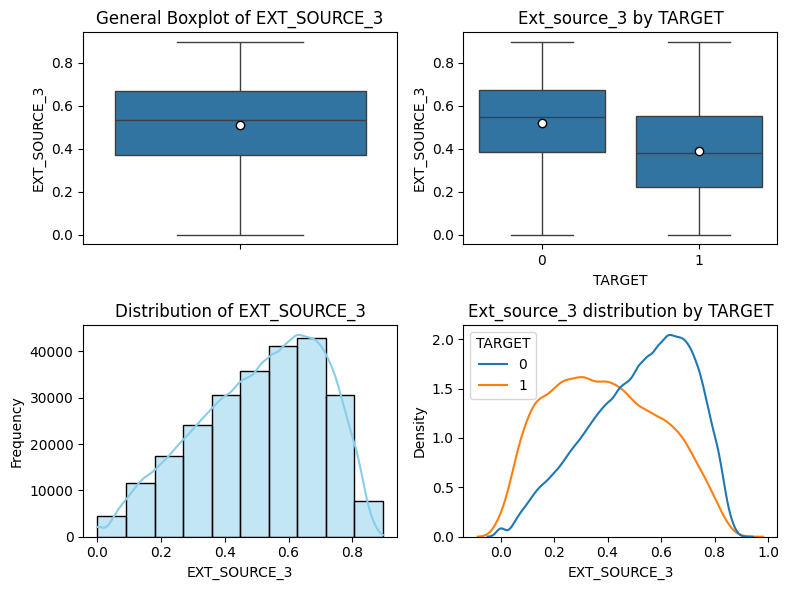

In [71]:
plot_distribution_numerical(df_train, top_features[0])

There are no significant outliers in the boxplots. The feature's distribution is nearly normal, with a slight left skew. 

Both the boxplot and KDE plot show that lower values of EXT_SOURCE_3 are associated with a higher probability of loan default (Target = 1), making this a highly impactful feature

    EXT_SOURCE_2 - Normalized score from external data source.

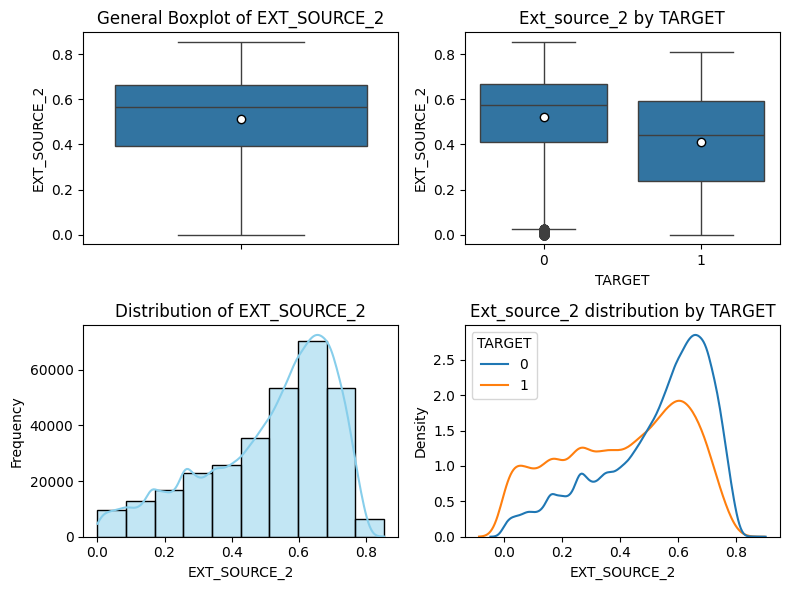

In [72]:
plot_distribution_numerical(df_train, top_features[1])

There are no significant outliers in the boxplots. The feature's distribution is nearly normal, with a slight left skew. 

Both the boxplot and KDE plot show that lower values of EXT_SOURCE_2 are associated with a higher probability of loan default (Target = 1), making this a highly impactful feature

    EXT_SOURCE_1 - Normalized score from external data source.

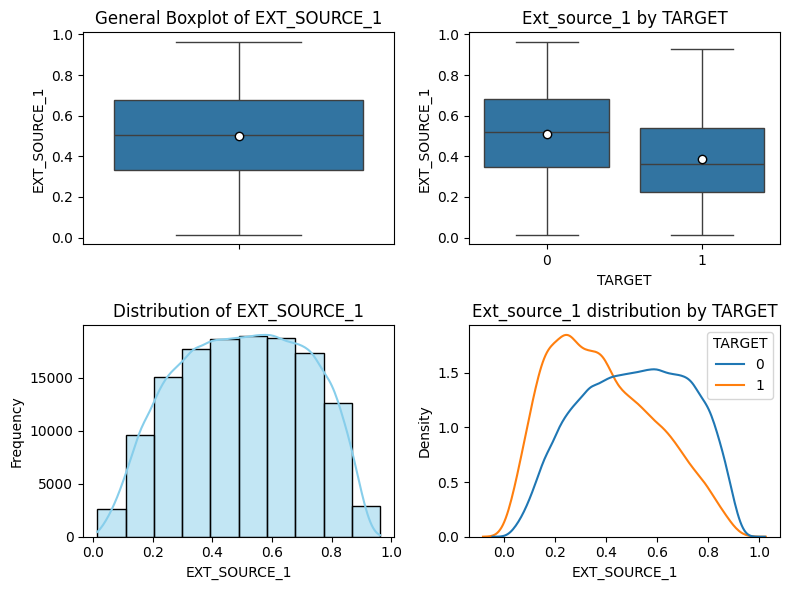

In [73]:
plot_distribution_numerical(df_train, top_features[2])

There are no significant outliers in the boxplots. The feature's distribution is nearly normal, but flat.

Both the boxplot and KDE plot show that lower values of EXT_SOURCE_1 are associated with a higher probability of loan default (Target = 1), making this a highly impactful feature

    YEARS_BIRTH - converted from DAYS_BIRTH - Client's age in days at the time of application,time only relative to the application.

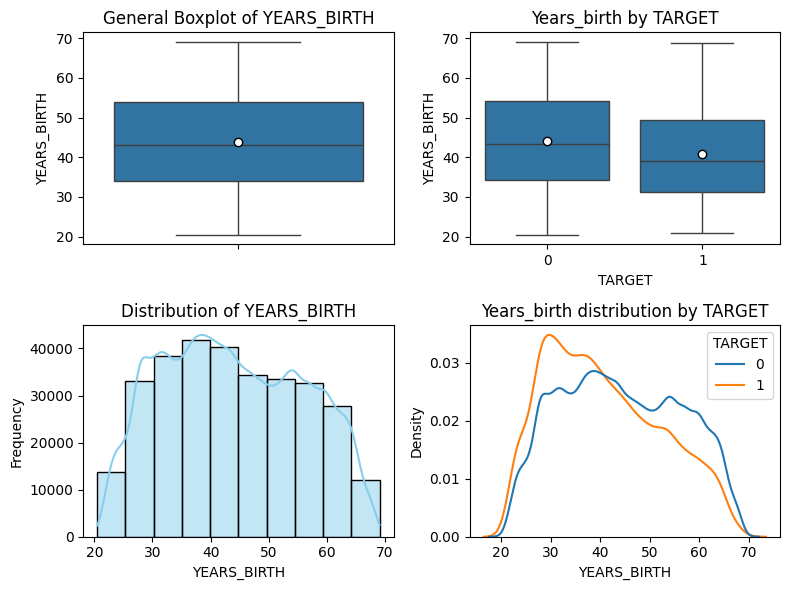

In [75]:
plot_distribution_numerical(train, top_features[3])

There are no significant outliers in the boxplots. The feature's distribution is nearly normal, right skewed.

Both the boxplot and KDE plot show that younger clients are associated with a higher probability of loan default (Target = 1), making this a highly impactful feature.

    OCCUPATION_TYPE - What kind of occupation does the client have

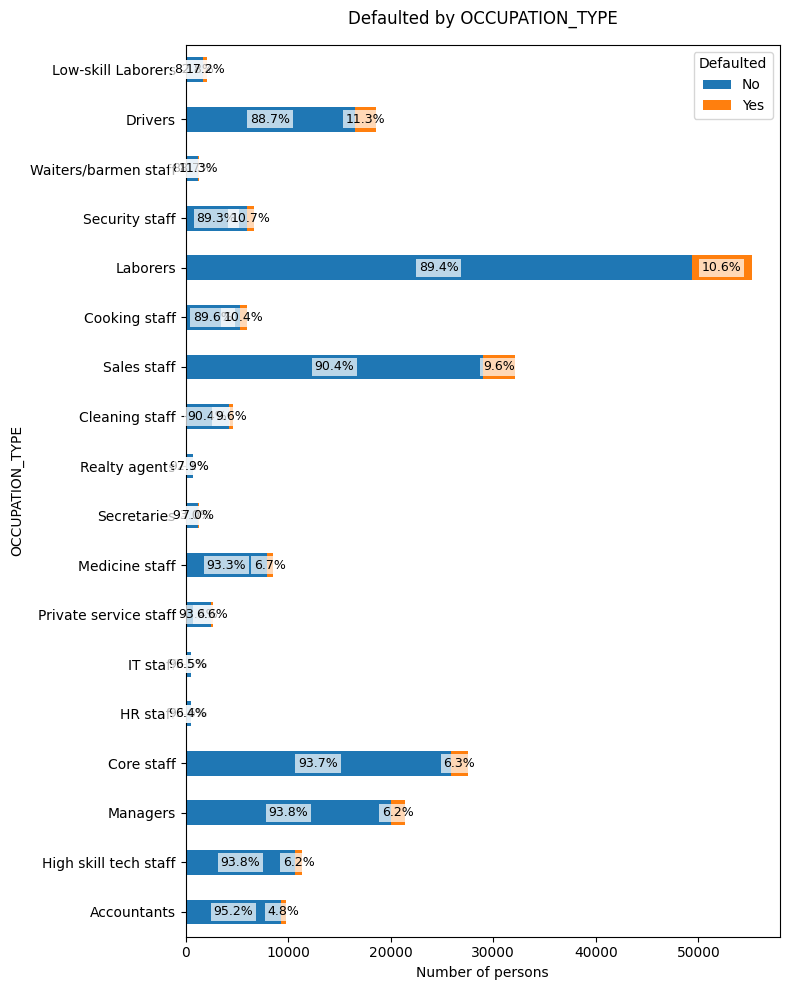

In [77]:
stacked_bar_with_percent(
    df_train,
    column_x=top_features[4],
    orientation="horizontal",
    sort_by_default=True,
    ascending=False,
    figsize=(8, 10),
)

Certain occupation types, such as Low-skill Laborers, Waiters/barmen, Drivers, and Laborers, exhibit a higher default rate higher than 10%, while others like Accountants, Managers, and High-skill tech staff show a lower default rate of under 7%. This disparity makes OCCUPATION_TYPE a highly impactful feature for predicting default

    ORGANIZATION_TYPE - Type of organization where client works

In [78]:
df_train["ORGANIZATION_TYPE"].nunique()

58

There are too much unique categories in ORGANIZATION_TYPE feature, we will plot only top 15

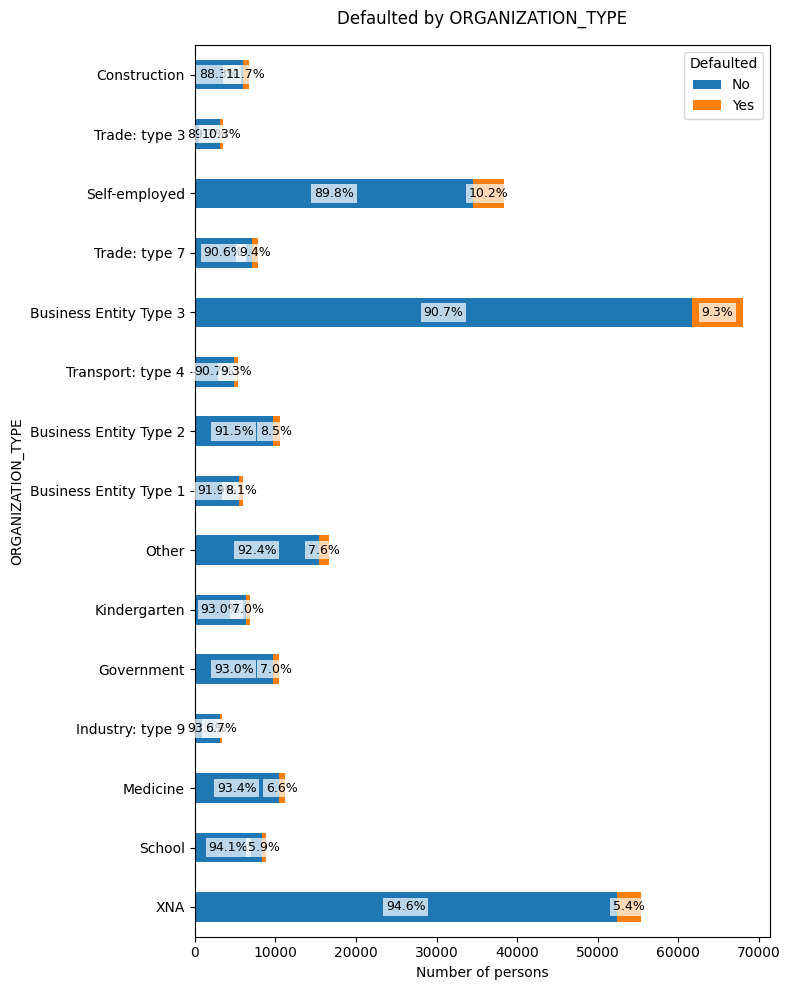

In [79]:
stacked_bar_with_percent(
    df_train,
    column_x=top_features[5],
    orientation="horizontal",
    sort_by_default=True,
    ascending=False,
    top_n=15,
    figsize=(8, 10),
)

There's a significant difference in default rate across various organization types. Clients who's occupation is in in Construction, Trade: type 3, or are Self-employed individuals show a higher default rate, with rates exceeding 10%. In contrast, clients associated with School, Medicine, and Industry: type 9 have a much lower default rate, with rates below 7%. This clear disparity suggests that the ORGANIZATION_TYPE feature is a strong predictor of loan default.

    NAME_INCOME_TYPE - Clients income type (businessman, working, maternity leave,…)

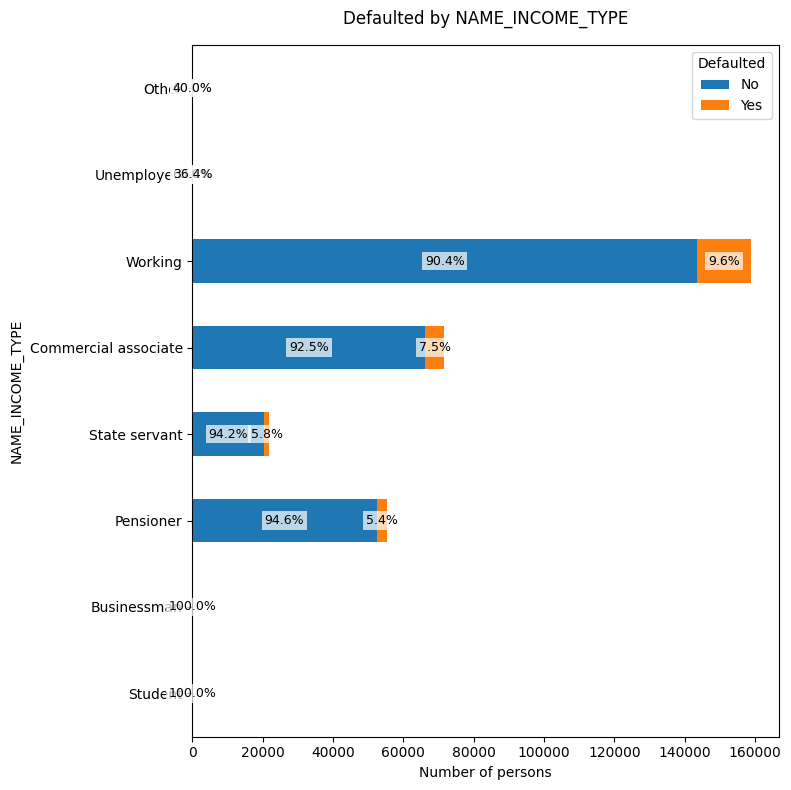

In [80]:
stacked_bar_with_percent(
    train,
    column_x=top_features[6],
    orientation="horizontal",
    sort_by_default=True,
    ascending=False,
    figsize=(8, 8),
)

The NAME_INCOME_TYPE feature is a strong predictor of loan default, particularly due to the extreme risk profiles of certain, albeit rare, categories.

    High-Risk Categories: The "Unemployed" and "Other" income types, while very rare in the dataset, show an exceptionally high default rate, with rates exceeding 30%.

    Low-Risk Categories: Conversely, the "Student" and "Businessman" categories, which are also rare, have a perfect default rate of 0%, indicating they are the safest borrowers.

    Common Categories: The most common income types, "Working", "Commercial associate",  "State servant" and "Pensioner," represent the bulk of the client base, with default rates form 9.6% to 5.4%. This data confirms that income type is a highly impactful feature for predicting a client's risk profile.

    REG_CITY_NOT_WORK_CITY - Flag if client's permanent address does not match work address (1=different, 0=same, at city level)

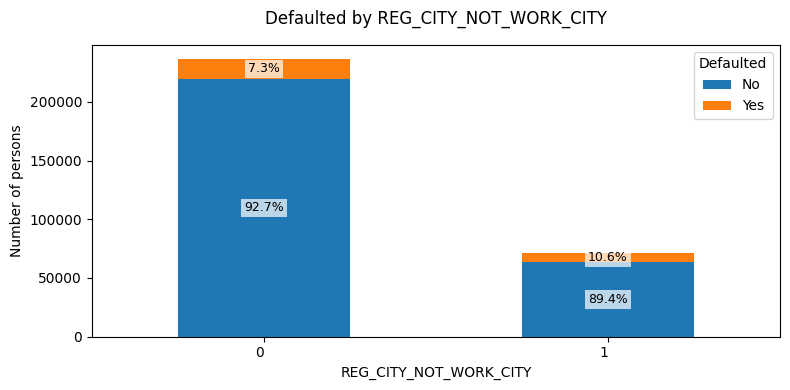

In [81]:
stacked_bar_with_percent(
    train,
    column_x=top_features[7],
    orientation="vertical",
    figsize=(8, 4),
)

Clients whose permanent address differs from their work address (at the city level) have a notably higher default rate of 10.6%. In contrast, clients who live and work in the same city show a lower default rate of 7.3%.

This suggests that having a stable, consistent living and work location is a strong indicator of lower credit risk. The discrepancy in addresses may be a proxy for other factors like financial instability or a less settled lifestyle, making this a highly predictive feature for loan default.

    YEARS_LAST_PHONE_CHANGE - converted from DAYS_LAST_PHONE_CHANGE,How many days before application did client change phone.

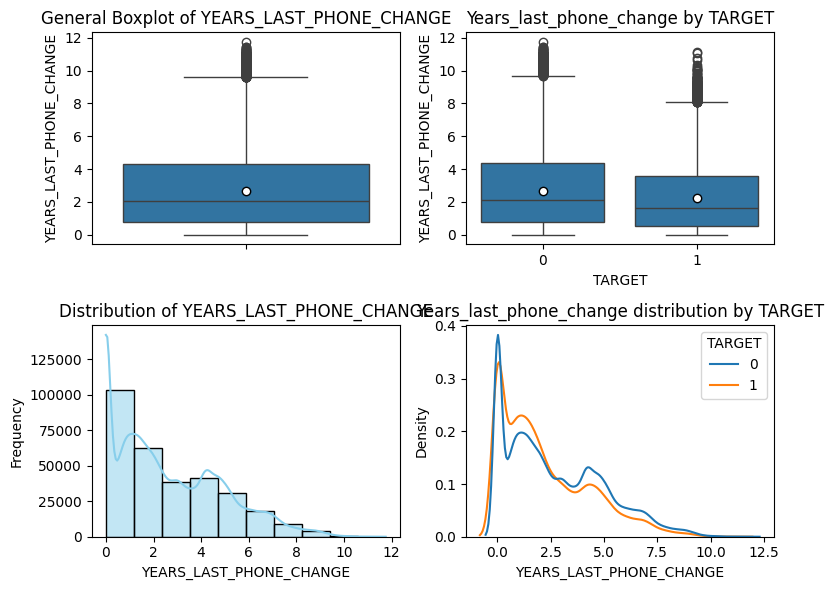

In [82]:
plot_distribution_numerical(train, top_features[8])

The YEARS_LAST_PHONE_CHANGE feature, while containing some outliers in the boxplots, does not present any significant anomalies, as a 12-year period is a reasonable timeframe for a client to not change their phone number. The analysis shows a clear relationship with the target variable:

    Boxplot Analysis: Clients who defaulted had a lower mean and median for phone change duration compared to those who did not default.

    KDE Plot Analysis: The KDE plot further supports this finding, indicating that defaulters tend to change their phone numbers more frequently, with the highest concentration of changes occurring within the first 0 to 2.5 years.

This suggests that recent changes in contact information could be an important risk indicator.

    ANOM_DAYS_EMPLOYED - flag for features DAYS_EMPLOYED values 365243 (How many days before the application the person started current employment,time only relative to the application)

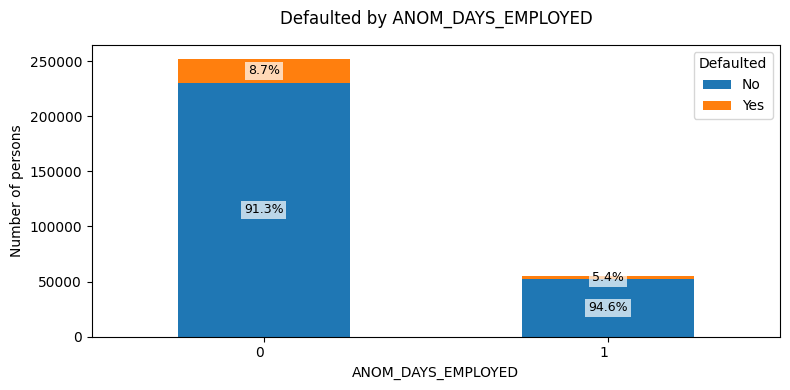

In [27]:
stacked_bar_with_percent(
    train,
    column_x=top_features[9],
    orientation="vertical",
    figsize=(8, 4),
)

Clients with an anomalous DAYS_EMPLOYED value of 365,243 (representing an employment history of approximately 1,000 years) have a significantly lower default rate of 5.4%. This is notably lower than the 8.7% default rate observed in the rest of the client population. 

This could suggests that the anomaly is not a data error that points to a higher risk, but rather a unique category of clients who are more reliable borrowers.

    FLAG_EMP_PHONE - Did client provide work phone (1=YES, 0=NO)

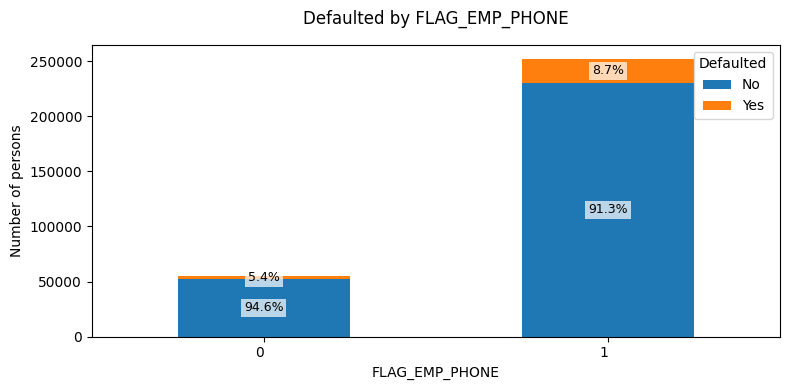

In [28]:
stacked_bar_with_percent(
    train,
    column_x=top_features[10],
    orientation="vertical",
    figsize=(8, 4),
)

Clients who provided their work phone number (FLAG_EMP_PHONE = 1) have a higher default rate of 8.7% compared to those who did not provide one (or whose phone was not verified), who have a lower default rate of 5.4%. This suggests that providing a work phone number is unexpectedly associated with a higher likelihood of default.

    YEARS_EMPLOYED - converted from DAYS_EMPLOYED - How many days before the application the person started current employment,time only relative to the application

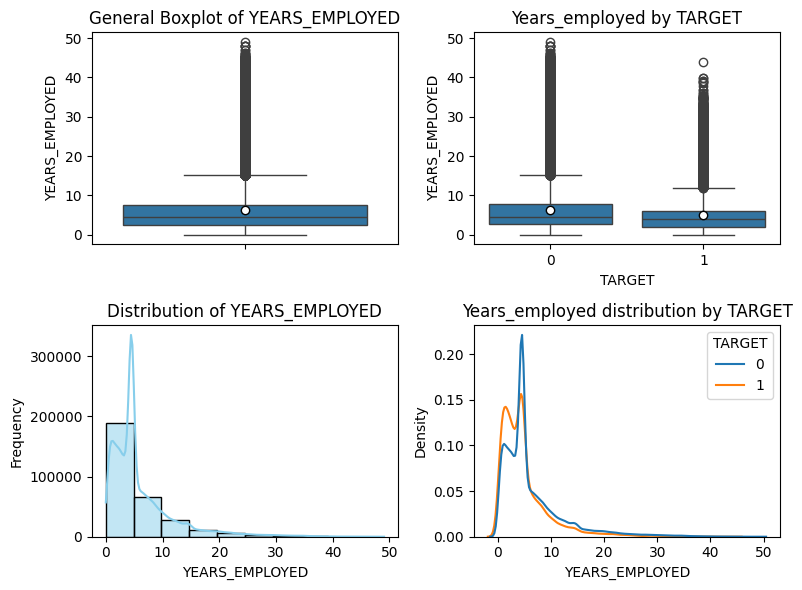

In [29]:
plot_distribution_numerical(train, top_features[11])

Clients with a longer employment history, as represented by the YEARS_EMPLOYED feature, tend to have a lower rate of defaulting.

    The anomalous value of 365,243 days has been replaced with the median to ensure a more accurate representation of the data.

    While the feature contains a number of outliers, these values are considered reasonable (up to 50 years) and will not be removed from the dataset.

    Both the boxplot and KDE plot show that defaulters have a lower mean and median for YEARS_EMPLOYED compared to non-defaulters. This indicates that clients with a shorter employment duration are at a higher risk of defaulting on their loan.

    REG_CITY_NOT_LIVE_CITY - Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)

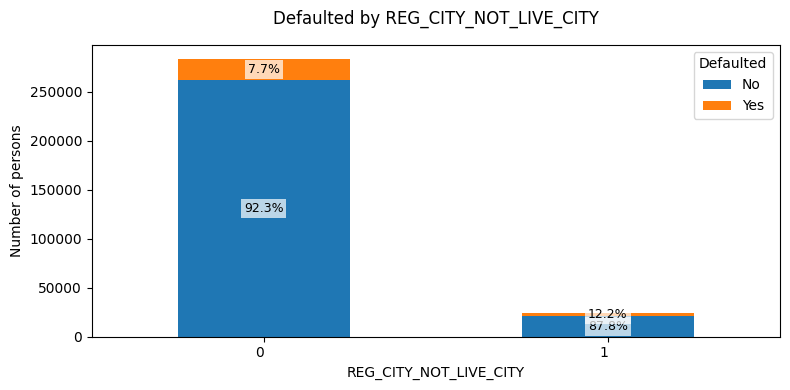

In [30]:
stacked_bar_with_percent(
    train,
    column_x=top_features[12],
    orientation="vertical",
    figsize=(8, 4),
)

Clients whose permanent address does not match their contact address (REG_CITY_NOT_LIVE_CITY = 1) show a significantly higher default rate of 12.2%. This is nearly double the default rate of 7.7% for clients whose addresses match. This discrepancy suggests that clients with a less stable or consistent address are at a higher risk of defaulting, making this a strong predictive feature.

    FLAG_DOCUMENT_3 - Did client provide document 3

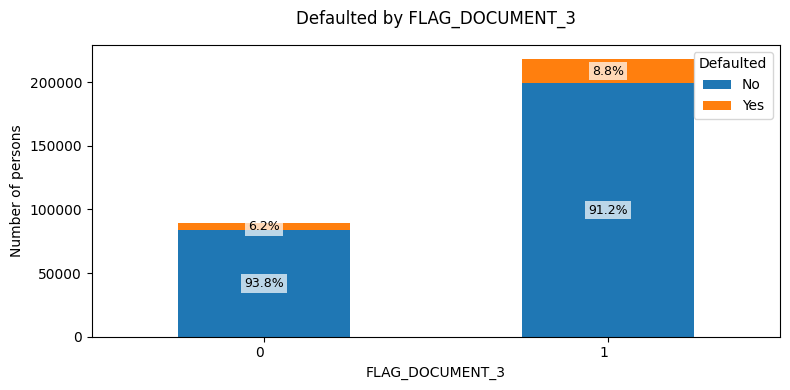

In [31]:
stacked_bar_with_percent(
    train,
    column_x=top_features[13],
    orientation="vertical",
    figsize=(8, 4),
)

Clients who provided Document 3 (FLAG_DOCUMENT_3 = 1) have a higher default rate of 8.8% compared to those who did not (FLAG_DOCUMENT_3 = 0), who have a lower default rate of 6.2%. This suggests that providing this specific document is correlated with a greater likelihood of default.

    YEARS_ID_PUBLISH - converted from DAYS_ID_PUBLISH - How many days before the application did client change the identity document with which he applied for the loan,time only relative to the application

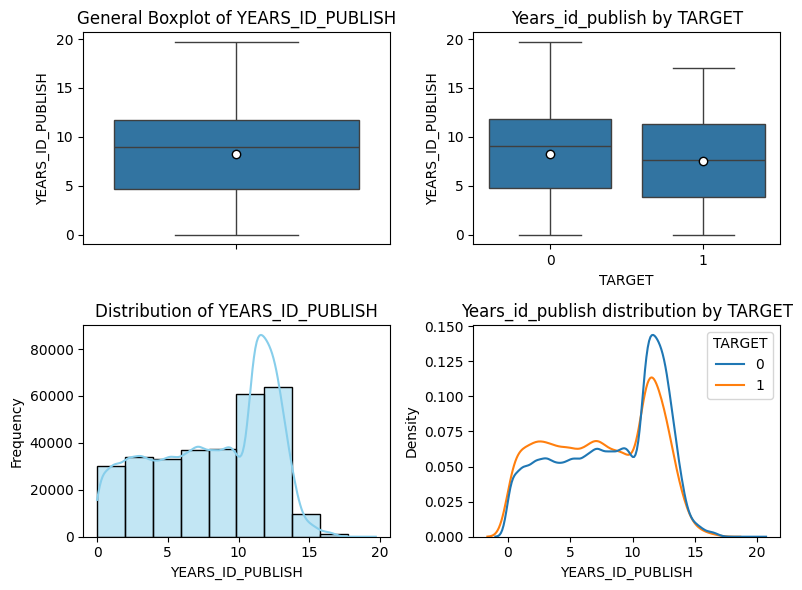

In [32]:
plot_distribution_numerical(train, top_features[14])

Clients who have more recently changed their identity documents have a higher risk of defaulting.

The YEARS_ID_PUBLISH feature, has no significant outliers.

The boxplot and KDE plot analyses show that clients who defaulted have a lower mean and median for this feature. This indicates that defaulters tend to change their identity documents more frequently and closer to the loan application date, suggesting a potential instability that is a strong indicator of credit risk.

    HOUSETYPE_MODE - Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

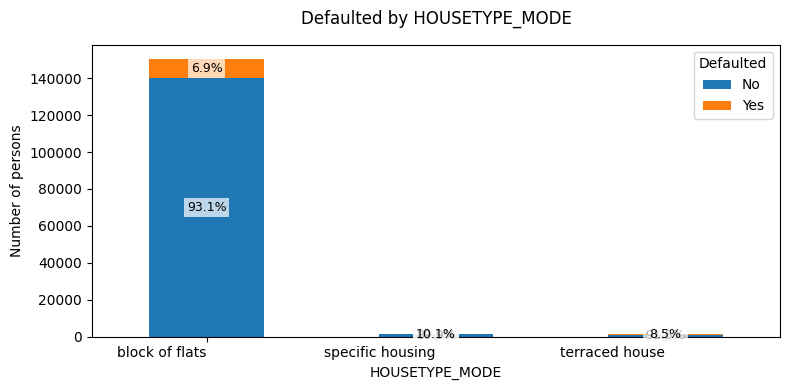

In [33]:
stacked_bar_with_percent(
    df_train,
    column_x=top_features[15],
    orientation="vertical",
    figsize=(8, 4),
)

Clients living in specific housing have the highest default rate at 10.1%. Those in terraced houses have a lower, but still significant, default rate of 8.5%. The most secure borrowers in this feature are clients living in a block of flats, with a default rate of just 6.9%. This suggests that housing type is a relevant indicator of a client's credit risk.

    OCCUPATION_TYPE_MISSING - missing flag for OCCUPATION_TYPE - What kind of occupation does the client have

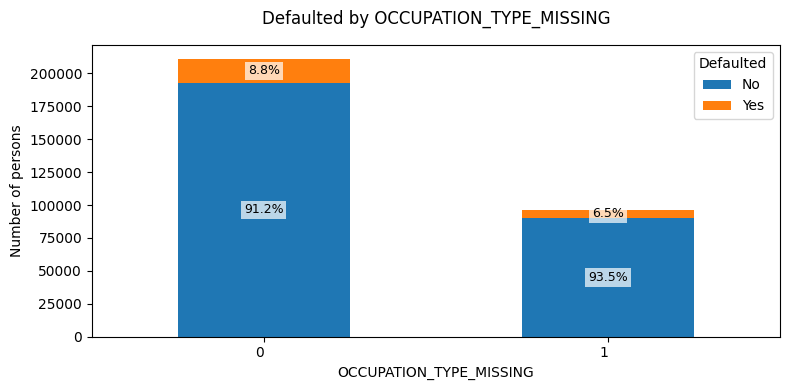

In [34]:
stacked_bar_with_percent(
    train,
    column_x=top_features[16],
    orientation="vertical",
    figsize=(8, 4),
)

Clients with a missing value for their OCCUPATION_TYPE (OCCUPATION_TYPE_MISSING = 1) have a lower default rate of 6.5%. This is in contrast to clients who provided this information (OCCUPATION_TYPE_MISSING = 0), who have a higher default rate of 8.8%. This suggests that the absence of occupation data is unexpectedly associated with a lower credit risk.

    AMT_GOODS_PRICE - Goods price of good that client asked for (if applicable) on the previous application

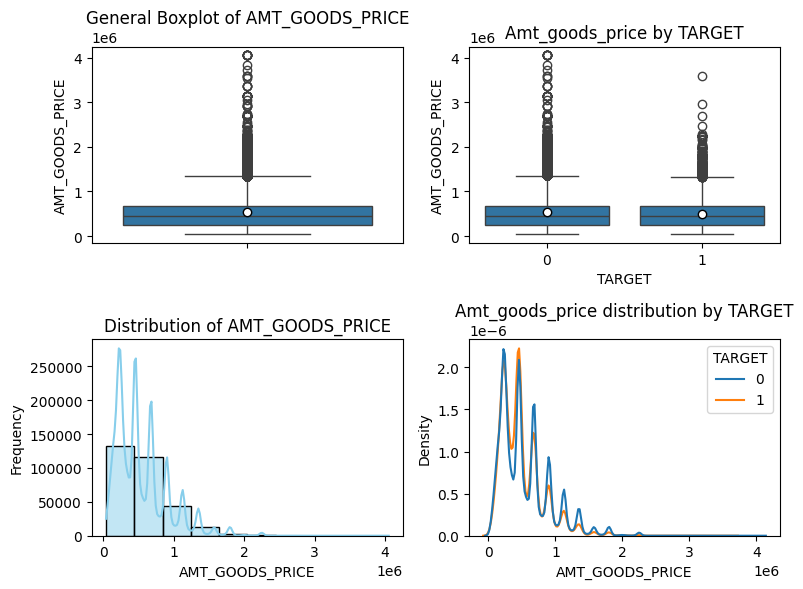

In [35]:
plot_distribution_numerical(train, top_features[17])

The data shows that most clients requested a goods price under 1M. While there are a number of outliers, with some values reaching up to 4M, these are not considered anomalies as they represent a realistic range of previous loan amounts.

The boxplot and histogram analysis show that defaulters have a slightly lower mean goods price compared to those who did not default. This suggests that clients who request a lower loan amount on previous applications may have a slightly higher risk of defaulting.

    WALLSMATERIAL_MODE - ormalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor",normalized

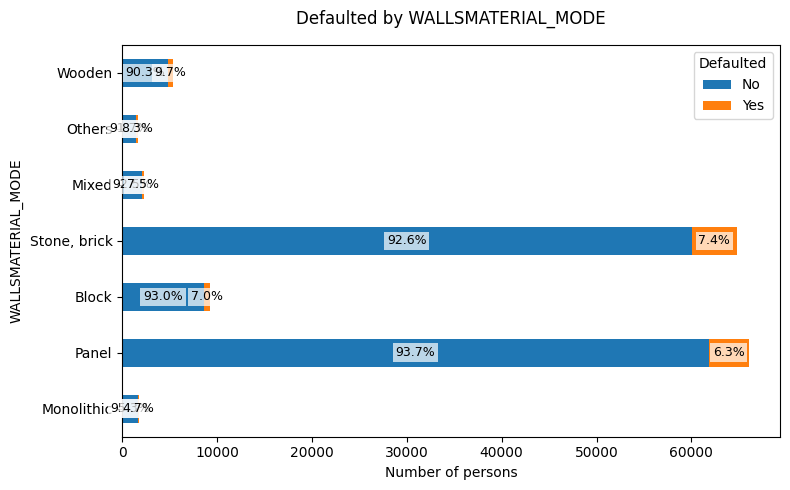

In [36]:
stacked_bar_with_percent(
    df_train,
    column_x=top_features[18],
    orientation="horizontal",
    sort_by_default=True,
    ascending=False,
    figsize=(8, 5),
)

Clients living in buildings with wooden walls have the highest default rate at 9.7%. This is significantly higher than those living in buildings with panel walls (6.3%) or monolith walls, which have the lowest default rate at just 4.7%. This suggests that the type of building material is a strong predictor of a client's risk profile.

    AMT_CREDIT - Credit amount of the loan

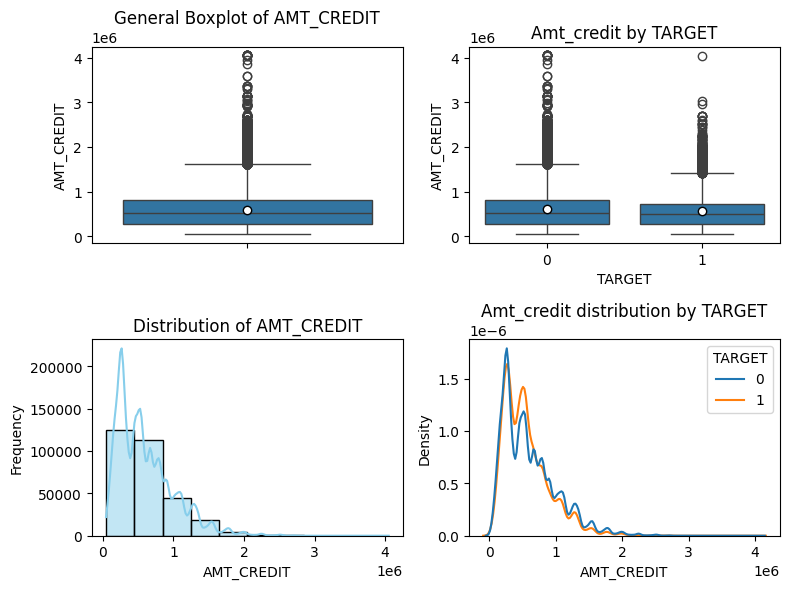

In [37]:
plot_distribution_numerical(train, top_features[19])

The AMT_CREDIT distribution is right-skewed, with most loan amounts falling under 1M. While there are outliers up to 4M, these values are considered reasonable and do not represent anomalies.

The analysis shows that defaulters tend to have a slightly lower median credit amount than non-defaulters. This suggests that a higher concentration of loan defaults occurs in the lower loan amount brackets.

    NAME_FAMILY_STATUS - Family status of the client

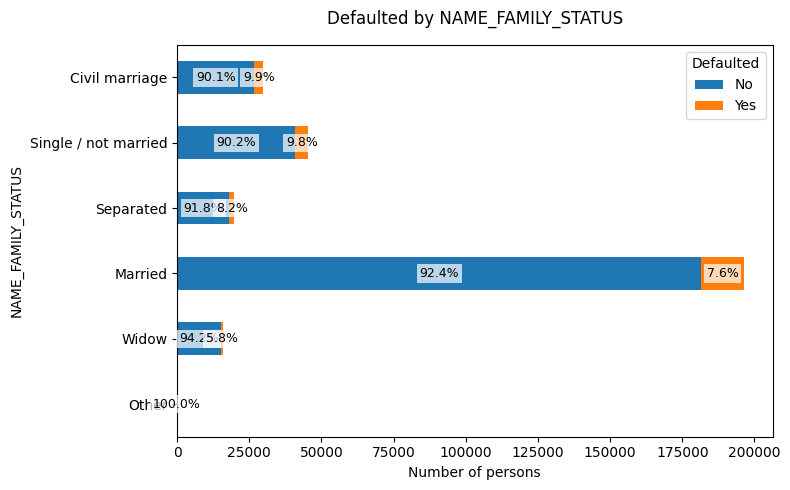

In [38]:
stacked_bar_with_percent(
    train,
    column_x=top_features[20],
    orientation="horizontal",
    sort_by_default=True,
    ascending=False,
    figsize=(8, 5),
)

Clients who are in a civil marriage have the highest default rate at 9.9%. Following them are those who are single or not married, with a default rate of 9.8%.

In contrast, clients with more traditional family statuses show lower default rates: separated clients are at 8.2%, married clients at 7.6%, and widowed clients have the lowest risk at 5.8%. This suggests a strong correlation between family status and loan repayment behavior.

    YEARS_REGISTRATION - converted from DAYS_REGISTRATION - How many days before the application did client change his registration,time only relative to the application

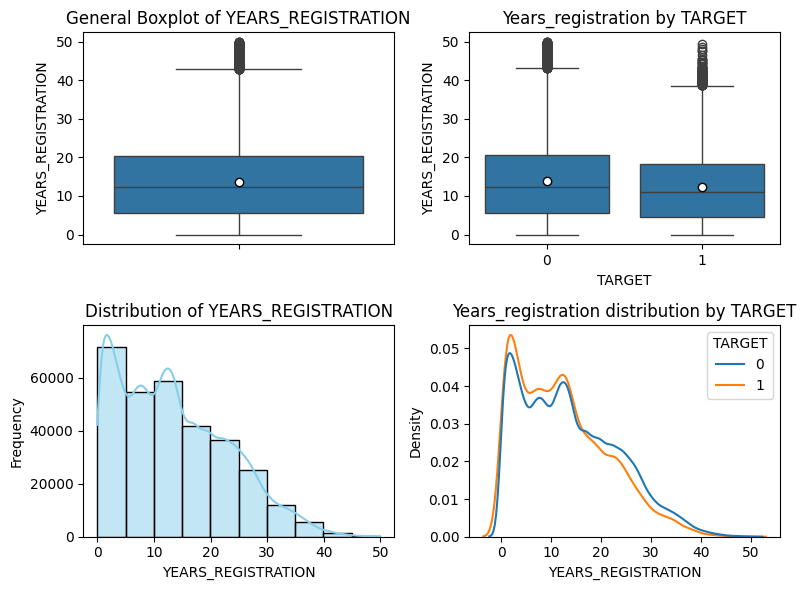

In [39]:
plot_distribution_numerical(train, top_features[21])

The distribution is right-skewed, and while there are many outliers, they were capped at 50 years to ensure they are within a reasonable range.

The boxplot and KDE plot analyses show that clients who defaulted have a lower mean registration period. This suggests that clients who more recently changed their registration are at a higher risk of defaulting on their loan.

    FLOORSMAX_AVG - Normalized information about building where the client lives, What is average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment size, common area, living area, age of building, number of elevators, number of entrances, state of the building, number of floor

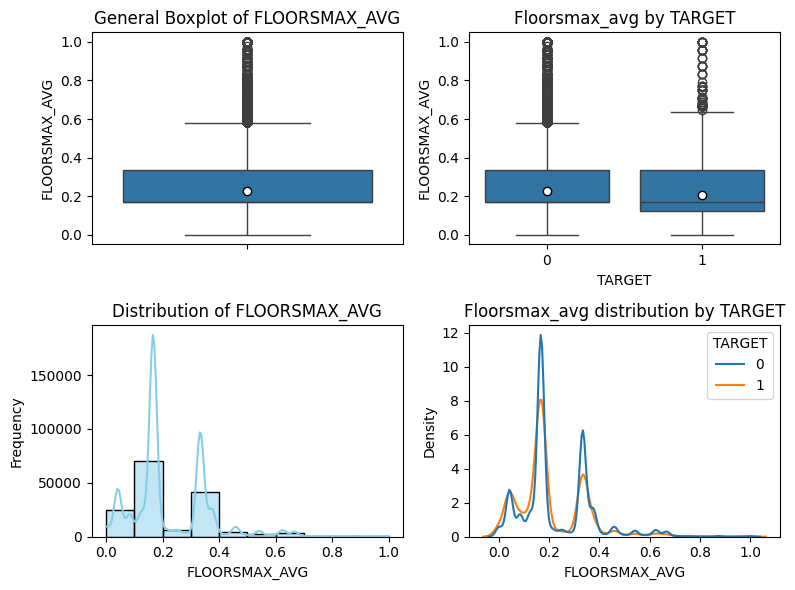

In [40]:
plot_distribution_numerical(df_train, top_features[22])

The data for this feature is concentrated between 0 and 0.6, with some outliers reaching up to 1. This suggests that most clients live in buildings with a lower number of floors. Analysis shows that clients who default have a lower mean for FLOORSMAX_AVG. This indicates that clients living in buildings with a lower average number of floors are at a higher risk of defaulting on their loan.

    BUILDING_INFO_MISSING_COUNT - counts for missing features related with building information per client.

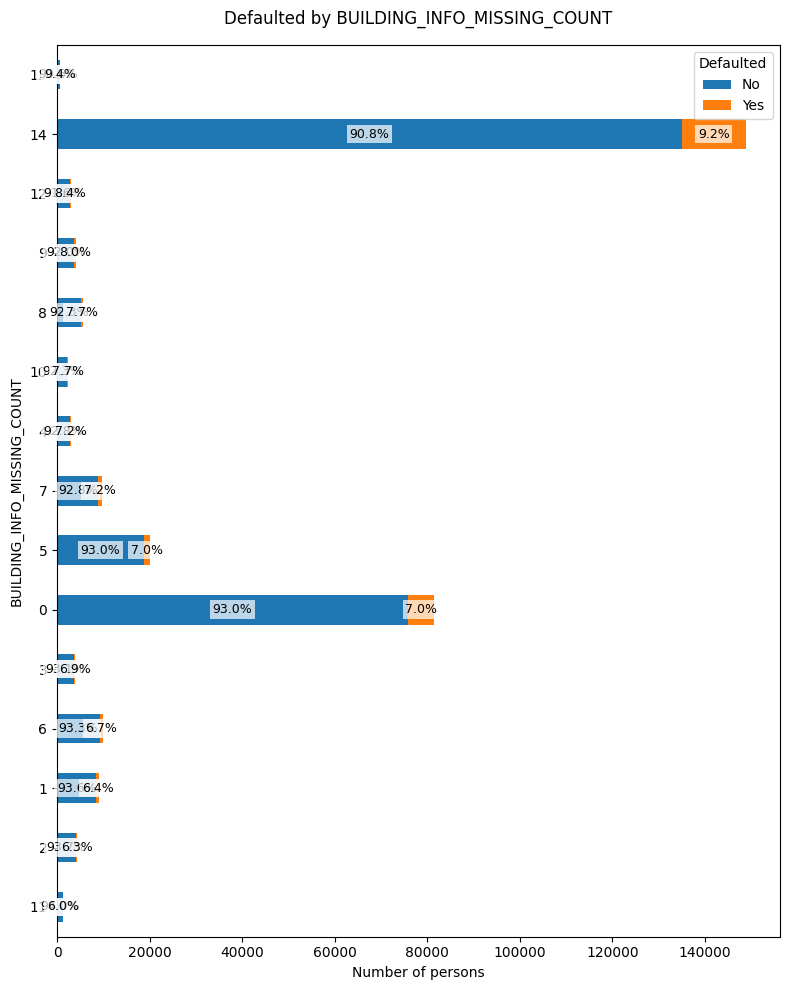

In [41]:
stacked_bar_with_percent(
    train,
    column_x=top_features[23],
    orientation="horizontal",
    sort_by_default=True,
    ascending=False,
    figsize=(8, 10),
)

Clients with a high number of missing building-related features (specifically, 13 missing values) have a higher default rate of 9.2%. This is significantly higher than the 7.0% default rate for clients who have provided all of their building information (i.e., 0 missing values). This suggests that a client's willingness or ability to provide complete information about their living situation is a strong indicator of their credit risk.

    NAME_HOUSING_TYPE - What is the housing situation of the client (renting, living with parents, ...)

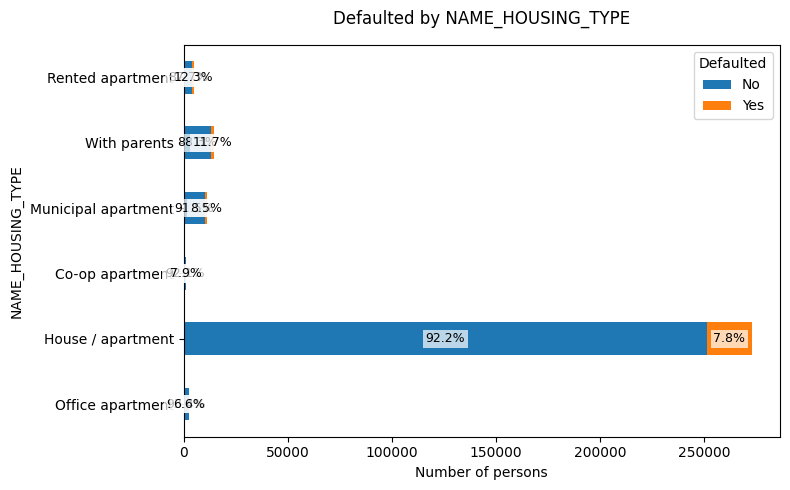

In [42]:
stacked_bar_with_percent(
    train,
    column_x=top_features[24],
    orientation="horizontal",
    sort_by_default=True,
    ascending=False,
    figsize=(8, 5),
)

Clients who are in a less stable housing situation, such as Rented apartments (12.3% default rate) or living With parents (11.7% default rate), have a much higher risk of defaulting. The largest group, clients living in their own House/apartment, has a default rate of 7.8%, which is very close to the overall dataset average of 8.1%. The lowest risk is for clients in an Office apartment, with a default rate of 6.8%. This suggests that stable, independent housing is a key factor in predicting lower credit risk.

#### Phik Correlation Heatmap – Top 10 Features and TARGET

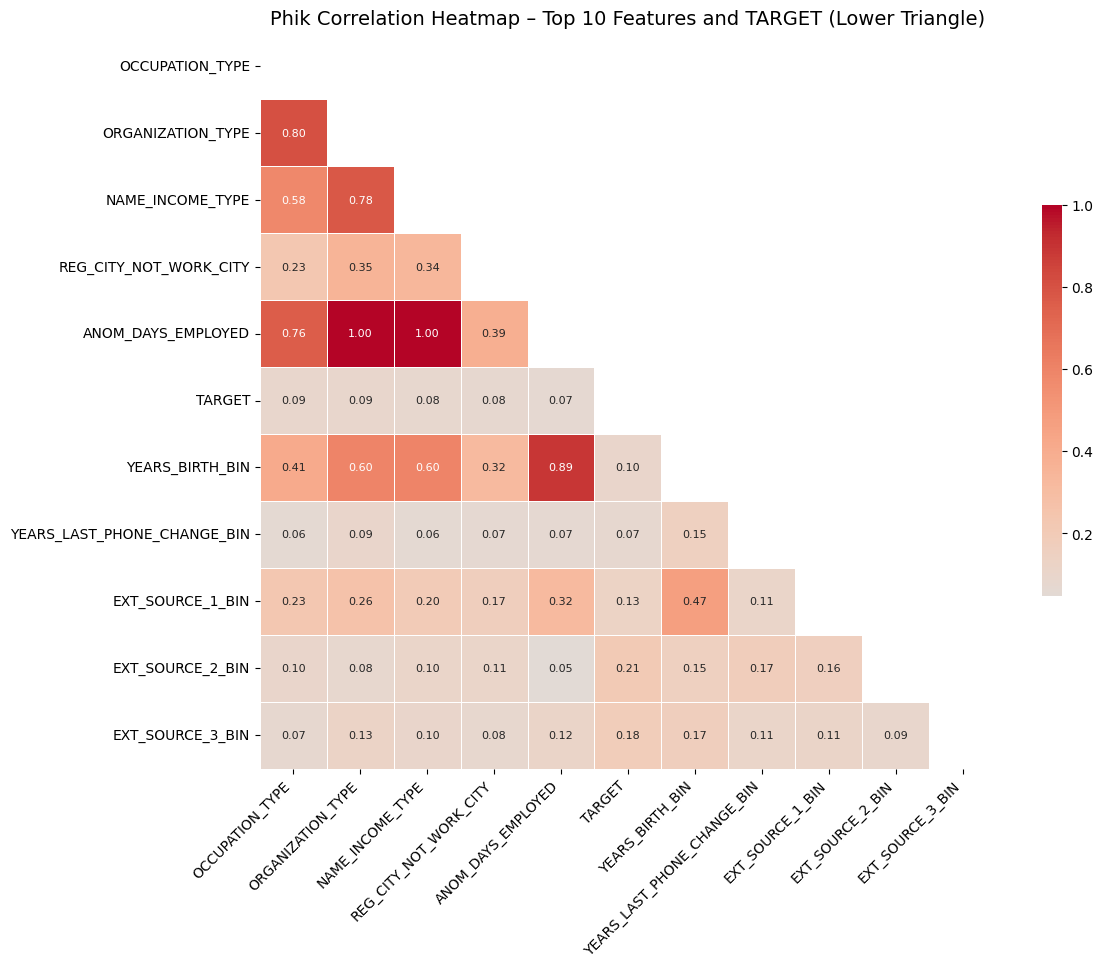

In [49]:
selected_features = list(top_features[:10])
selected_features.append("TARGET")

df_top = train[selected_features].copy()

df_top["YEARS_BIRTH_BIN"] = pd.qcut(df_top["YEARS_BIRTH"], q=20, duplicates="drop")
df_top["YEARS_LAST_PHONE_CHANGE_BIN"] = pd.qcut(
    df_top["YEARS_LAST_PHONE_CHANGE"], q=20, duplicates="drop"
)
df_top["EXT_SOURCE_1_BIN"] = pd.qcut(df_top["EXT_SOURCE_1"], q=20, duplicates="drop")
df_top["EXT_SOURCE_2_BIN"] = pd.qcut(df_top["EXT_SOURCE_2"], q=20, duplicates="drop")
df_top["EXT_SOURCE_3_BIN"] = pd.qcut(df_top["EXT_SOURCE_3"], q=20, duplicates="drop")

df_top = df_top.drop(
    [
        "YEARS_BIRTH",
        "YEARS_LAST_PHONE_CHANGE",
        "EXT_SOURCE_1",
        "EXT_SOURCE_2",
        "EXT_SOURCE_3",
    ],
    axis=1,
)

corr_matrix = df_top.phik_matrix(interval_cols=[])


mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot=True,  # <- show values
    fmt=".2f",  # <- 2 decimal places
    annot_kws={"size": 8},  # <- smaller font so numbers fit
)
plt.xticks(rotation=45, ha="right")
plt.title(
    "Phik Correlation Heatmap – Top 10 Features and TARGET (Lower Triangle)",
    fontsize=14,
)
plt.tight_layout()
plt.show()

**Key insights**

OCCUPATION_TYPE – ORGANIZATION_TYPE (0.80)
    
    Occupation is strongly tied to the type of organization where the applicant works. For example, "Laborers" are more likely to be in manufacturing, while "Managers" in corporate organizations. This is expected — both reflect employment context.

NAME_INCOME_TYPE – ORGANIZATION_TYPE (0.78)

    Income source (e.g., "Working", "Pensioner", "Commercial associate") strongly depends on the organization type.

ANOM_DAYS_EMPLOYED – OCCUPATION_TYPE (0.76)

    The anomaly flag (999,999 for unknown employment duration) is highly linked to occupation type. Applicants without a valid occupation often have anomalous values for employment duration.

ANOM_DAYS_EMPLOYED – ORGANIZATION_TYPE (1.00)

    Perfect association: anomalies in DAYS_EMPLOYED are fully determined by organization type (e.g., people with missing/unknown employment usually have a special organization category like “XNA”).

ANOM_DAYS_EMPLOYED – NAME_INCOME_TYPE (1.00)
    
    Same as above: anomalies in employment duration are completely explained by income type (pensioners, unemployed, students). Another sign of redundant encoding.

YEARS_BIRTH – ANOM_DAYS_EMPLOYED (0.89)

    Very high correlation. Younger applicants almost never have the anomaly, but older groups (retirees, unemployed) often have 999,999 as employment days. This suggests a demographic pattern.

All top 10 features shows low correlation with TARGET (0.07 - 0.21).
    EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 has highest correlation compared to other features, but still low.

Multicollinearity analysis (e.g., VIF) will not be a primary focus. While important for linear models, it is less critical for tree-based models like LightGBM and XGBoost, on which our efforts are concentrated. A baseline Logistic Regression model will be run, but our final model selection will be between the tree-based algorithm

### G. Statistical inference

**1. Target Population**

Target population: 
    
    all applicants represented by train/test dataset, people who applied for a Home Credit loan.

Sample size:
    
    307,511 individuals included in the data set.

The target variable
    
    TARGET Defaulted (binary: 1 True / 0 False).

We want to infer about relationships between features and "TARGET" / Default status.

We'll examine these relationships with threshold for statistical significance α = 0.05.

**2. Hypotheses testing**

**Numeric Variable (YEARS_BIRTH) vs. Binary Target (TARGET)**

**Hypothesis 1: Average age differs between clients who default and not default**

    Is there a significant difference in the mean age (YEARS_BIRTH) between clients who have payment difficulties (TARGET=1) and those who do not (TARGET=0)?
    
     The difference in population means, μ₀ - μ₁ (Mean age of Non-Defaulters minus Mean age of Defaulters).

Statistical Test: Two-Independent Sample Z-Test for Means.

    Sample size is very large, plot distribution close to normal, so we can accurately estimate the population standard deviation from the sample.

H₀ (Null Hypothesis): There is no difference in mean age between the two groups.

**H₁ (Alternative Hypothesis): There is a difference in mean age between the two groups.**

In [16]:
group_good = train[train["TARGET"] == 0]["YEARS_BIRTH"]
group_bad = train[train["TARGET"] == 1]["YEARS_BIRTH"]

n_good, n_bad = len(group_good), len(group_bad)
mean_good, mean_bad = group_good.mean(), group_bad.mean()
std_good, std_bad = group_good.std(), group_bad.std()

se_diff = np.sqrt((std_good**2 / n_good) + (std_bad**2 / n_bad))

z_score = (mean_good - mean_bad) / se_diff

p_value = stats.norm.sf(abs(z_score)) * 2

ci_low = (mean_good - mean_bad) - 1.96 * se_diff
ci_high = (mean_good - mean_bad) + 1.96 * se_diff

print(f"Z-score: {z_score:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"95% CI for Difference in Means: ({ci_low:.4f}, {ci_high:.4f})")

Z-score: 45.0062
P-value: 0.0000
95% CI for Difference in Means: (3.2820, 3.5809)


P-value < α = 0.05 Reject Null Hypothesis.

There is statistical evidence that a client's age is associated with their likelihood of repayment.

    Clients without payment difficulties (TARGET=0) are, on average, 3.28 to 3.58 years older than clients with difficulties (TARGET=1), with 95% confidence. The infinitesimally small p-value (p ≈ 0.000) confirms this difference is not due to random chance.

**Numeric Variable (AMT_CREDIT) vs. Binary Target (TARGET)**

**Hypothesis 2: There is difference in the mean credit amount (AMT_CREDIT) between clients who default and not default**

    Is there a significant difference in the mean credit amount (AMT_CREDIT) between clients who default vs. those who do not?

    The difference in population means, μ₀ - μ₁.

    AMT_CREDIT distribution are highly right-skewed. We will use Mann–Whitney U test.

H₀ (Null Hypothesis): There is no difference in mean credit amount between the two groups.

**H₁ (Alternative Hypothesis): There is a difference in mean credit amount between the two groups.**

In [19]:
Default_0 = train[train["TARGET"] == 0]["AMT_CREDIT"]
Default_1 = train[train["TARGET"] == 1]["AMT_CREDIT"]

stat, p = mannwhitneyu(Default_1, Default_0, alternative="two-sided")
print(f"Mann-Whitney U Test p-value: {p:.4f}")

Mann-Whitney U Test p-value: 0.0000


P-value < α = 0.05 Reject Null Hypothesis.

    There is a statistically significant difference in mean credit amount between clients who default and not default.

In [20]:
alpha = 0.05


def bootstrap_mean_diff(x, y, n_boot=5000, seed=42):
    rng = np.random.RandomState(seed)
    x = np.array(x.dropna())
    y = np.array(y.dropna())
    boot_diffs = []
    n_x, n_y = len(x), len(y)

    for _ in range(n_boot):
        bx = rng.choice(x, size=n_x, replace=True)
        by = rng.choice(y, size=n_y, replace=True)
        boot_diffs.append(bx.mean() - by.mean())

    boot_diffs = np.array(boot_diffs)
    mean_diff = boot_diffs.mean()
    ci_lower = np.percentile(boot_diffs, 100 * alpha / 2)
    ci_upper = np.percentile(boot_diffs, 100 * (1 - alpha / 2))

    return mean_diff, ci_lower, ci_upper


mean_diff, lo, hi = bootstrap_mean_diff(Default_0, Default_1)
print(f"Bootstrap mean difference (TARGET=0 - TARGET=1): {mean_diff:,.2f}")
print(f"95% CI: [{lo:,.2f}, {hi:,.2f}]")

Bootstrap mean difference (TARGET=0 - TARGET=1): 44,873.85
95% CI: [40,196.48, 49,279.27]


On average, customers who did not default (TARGET=0) had loan amounts about 44.9k higher than those who defaulted. 

**The 95% confidence interval [40,196.48, 49,279.27] does not include 0, so the difference is statistically significant.**

    This suggests that clients taking larger loans were less likely to default, possibly reflecting higher creditworthiness or better financial profiles.

**Categorical Variable (OCCUPATION_TYPE) vs. Binary Target (TARGET)**

**Hypothesis 3: There is an association between a client's occupation type and their likelihood of experiencing payment difficulties (default)?**

    Chi-Squared Test of Independence (to test if the entire OCCUPATION_TYPE variable is independent of TARGET).

H₀ (Null Hypothesis): OCCUPATION_TYPE and TARGET are independent. (Default rate is the same across all occupations).

H₁ (Alternative Hypothesis): OCCUPATION_TYPE and TARGET are not independent. (Default rate varies by occupation).

In [22]:
contingency_table = pd.crosstab(train["OCCUPATION_TYPE"], train["TARGET"])

chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nChi-Squared Test for OCCUPATION_TYPE vs. TARGET")
print(f"Chi2 Statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")


Chi-Squared Test for OCCUPATION_TYPE vs. TARGET
Chi2 Statistic: 1402.8468
P-value: 0.0000


P-value < α = 0.05 Reject Null Hypothesis. This means that the default rate is not the same across all occupation types.

    There is a statistically significant association between a client's occupation and their likelihood of experiencing payment difficulties (default).

**Summary of Statistical Inference Results**


**1. Age (YEARS_BIRTH) and Default:**

A client's age is significantly associated with repayment. Clients who did not default were, on average, **3.3 to 3.6 years older** than those who did.

**2. Loan Amount (AMT_CREDIT) and Default:**

A significant difference in loan amounts exists. Clients who did not default had loans that were, on average, **~44.9k higher**, suggesting larger loans were granted to more creditworthy individuals.

**3. Occupation (OCCUPATION_TYPE) and Default:**

A significant association exists between occupation and default rates. The likelihood of a client experiencing payment difficulties **varies significantly across different occupations.**

### H. Detect Anomalies

**Date features**

Some anomalies was handled while analyzing DAYS_ features:

    - Flag DAYS_EMPLOYED == 365243 → ANOM_DAYS_EMPLOYED = 1.
    - DAYS_REGISTRATION cap at 18250 days (~50 years)

Lets look at Children (CNT_CHILDREN) and Family members (CNT_FAM_MEMBERS) features.

**Children & Family features**

In [278]:
train["CNT_CHILDREN"].value_counts()

CNT_CHILDREN
0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
8          2
9          2
12         2
10         2
19         2
11         1
Name: count, dtype: int64

In [279]:
train["CNT_FAM_MEMBERS"].value_counts()

CNT_FAM_MEMBERS
2.0     158357
1.0      67847
3.0      52601
4.0      24697
5.0       3478
6.0        408
7.0         81
8.0         20
9.0          6
10.0         3
14.0         2
12.0         2
20.0         2
16.0         2
13.0         1
15.0         1
11.0         1
Name: count, dtype: int64

While it's possible for a client to have more than 7 children or 9 family members, these values are considered highly unusual and can be treated as anomalies. To address this and prevent these extreme values from skewing our model, we will **cap the number of children at 7 and the number of family members at 9.** 

A new binary flag will also be created to explicitly identify these anomalous cases, allowing us to analyze their unique characteristics and predictive power. This ensures our model is robust while still capturing potential insights from these rare instances.

**Financial features**

AMT_CREDIT and AMT_GOODS_PRICE were identified as highly impactful in the Phik correlation analysis, ranking among the top 25 features. While a visual inspection of these features revealed the presence of outliers, these values appear to be reasonable and do not represent data anomalies. They likely reflect genuine loan amounts and goods prices that are on the higher end of the distribution, and will therefore be retained for modeling.

We will check AMT_INCOME_TOTAL feature.

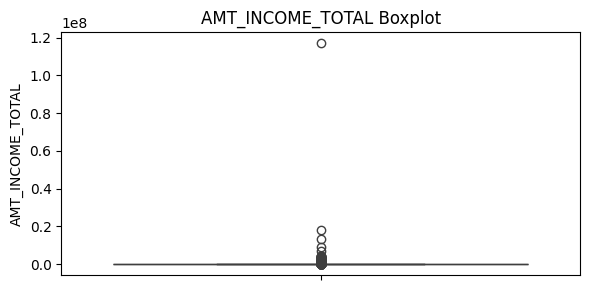

In [53]:
plt.figure(figsize=(6, 3))
sns.boxplot(train["AMT_INCOME_TOTAL"])
plt.title("AMT_INCOME_TOTAL Boxplot")
plt.tight_layout()

Extreme outlier, we will replace it with median.

**Other feature**

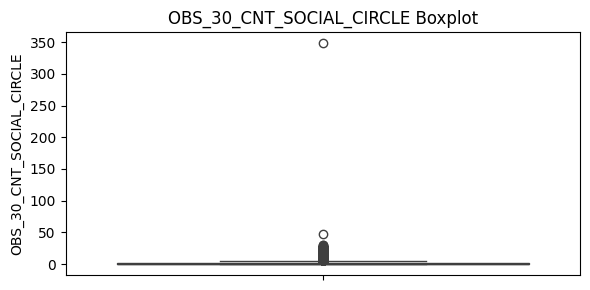

In [54]:
plt.figure(figsize=(6, 3))
sns.boxplot(train["OBS_30_CNT_SOCIAL_CIRCLE"])
plt.title("OBS_30_CNT_SOCIAL_CIRCLE Boxplot")
plt.tight_layout()

Extreme outlier, we will cap OBS_30_CNT_SOCIAL_CIRCLE values on 99.9%.

All these anomalies will be handled by handle_anomalies function.

### I. Feature Engineering

Feature engineering involves transforming our existing data and creating new features to improve our model's predictive performance.

All feature engineering steps discussed in this notebook are encapsulated within a dedicated **feature_engineering** function. 

This function will be systematically applied to both the main training and test datasets through the **preprocess_features function**, ensuring consistency and reproducibility across our entire pipeline.

This notebook contains only explanations (do not include code itself of  **feature_engineering** function).

**1. Financial Ratios**

These ratios are classic predictors in credit risk modeling, as they measure affordability and leverage.

    Debt-to-Income (DTI): AMT_ANNUITY / AMT_INCOME_TOTAL
        higher values = applicant spends a larger share of income on loan repayments.

    Credit-to-Income: AMT_CREDIT / AMT_INCOME_TOTAL
        checks if requested loan is proportional to income.

    Annuity-yo-Credit: AMT_ANNUITY / AMT_CREDIT
        measures what fraction of the loan must be repaid annually.
        High values may indicate short loan term (high repayments relative to loan size).
        Low values may indicate long-term, stretched loans.

    Loan-to-Value (LTV): AMT_CREDIT / AMT_GOODS_PRICE
        how much of the goods’ value is financed; capped at 2× to prevent outliers.

    Goods Price to Income (GOODS_TO_INCOME): AMT_GOODS_PRICE / AMT_INCOME_TOTAL.
        indicates whether applicants are buying disproportionately expensive goods relative to income (higher default risk).



**2. Asset Ownership**

    Owning a car or real estate may indicate stronger financial standing. We create a simple asset score by summing these binary flags.

**3. Contactability / Phone change feature**

Multiple phone flags exist in the dataset (FLAG_MOBIL, FLAG_EMP_PHONE, etc.). Instead of treating them separately, we collapse them into one binary indicator:

    PHONE_PROVIDED = 1 if applicant has any phone registered, else 0.

        This helps measure whether the applicant is reachable, which can be linked to default risk.

    Phone Changed Recently (PHONE_CHANGED_RECENTLY), Uses YEARS_LAST_PHONE_CHANGE.

        Applicants who recently changed phone numbers may be less stable or harder to contact.

**4. External Scores (EXT_SOURCE)**

The EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3 variables are powerful external risk ratings. To enrich them:

    We add squared terms (EXT_SOURCE_1_SQ, etc.) to capture non-linear effects.

    We compute mean and standard deviation across all three.

    We create pairwise interactions (e.g., EXT_SOURCE_1 × EXT_SOURCE_2).

**5. Regional and City Stability**

Applicants who live and work in different regions/cities may have unstable situations. We aggregate mismatch indicators:

    Region Mismatch Sum (REGION_MISMATCH_SUM)
    
    Flag (REGION_MISMATCH_FLAG)

        Sum mismatch and Binary flag indicating if an applicant’s live/work/registered region is inconsistent.

    CITY_MISMATCH_SUM

       Geographic instability may be predictive of risk.

**6. Application Timing**

The time of application may reveal behavioral signals:

    Weekday: one-hot encoded (APP_WEEKDAY_MONDAY, etc.).

    Hour bucket: grouped into Morning, Afternoon, Evening, Other.

**7. Age features**

Bins applicants by age (YEARS_BIRTH) into ranges (18–25, 26–35, 36–50, 50+).

    Captures nonlinear effects where risk can vary sharply by age group rather than linearly with age.

We normalize employment and registration duration by applicant’s age to get relative measures.

    EMPLOY_AGE_RATIO = YEARS_EMPLOYED / YEARS_BIRTH
        % of life spent employed.

    REGISTRATION_AGE_RATIO = YEARS_REGISTRATION / YEARS_BIRTH
        % of life spent at current registered address.

Stable applicants typically have higher ratios.

**8. Document Provision Score / Any Document Flag**

Applicants are asked to submit up to 20+ documents (FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, …):
    
    We create an aggregate score: DOCUMENT_SCORE = total number of documents provided.

    Flag if applicant has provided at least one supporting document: ANY_DOCUMENT_PROVIDED
       
More documents often indicate transparency and lower fraud risk and lack of documents may correlate with weaker creditworthiness or fraud.

**9. Social Circle Default Rates**

The dataset tracks how many people in an applicant’s social circle had defaults.
We convert raw counts into rates to normalize across different observation sizes:

    SOCIAL_30_DPD_RATE = DEF_30 / OBS_30
    
    SOCIAL_60_DPD_RATE = DEF_60 / OBS_60

This provides a proxy for peer risk - applicants surrounded by defaulters may themselves have higher default probability.

**10. Registration vs. ID Publish Difference (REGISTRATION_ID_DIFF)**

    Difference between YEARS_REGISTRATION and YEARS_ID_PUBLISH.

    Large gaps might indicate inconsistencies in personal records (potential fraud risk).

**11. Housing Quality Score (HOUSING_QUALITY_SCORE)**

Encodes a combined feature from NAME_HOUSING_TYPE and WALLSMATERIAL_MODE.

Represents living conditions in a single score, potentially linked to socio-economic stability.

**12. Single With Children (SINGLE_WITH_CHILDREN)**

    Flag for applicants who are single (NAME_FAMILY_STATUS == "Single") but have children.

    Captures higher potential financial stress.

## 3. Summary Train & Test Datasets

**Dataset structure:**

    Train: 307,511 rows, 122 features (116 numeric, 16 categorical).

    Test: 48,744 rows, 121 features (115 numeric, 16 categorical).

    No duplicate records found.

**Missing values & redundancy:**

    High overall missingness (~97% in train, ~96% in test).

    Most missing columns are building-related (COMMONAREA, NONLIVINGAPARTMENTS).

    To simplify the dataset and reduce multicollinearity:

        - Retained only _AVG columns, dropped redundant _MEDI and _MODE.
        
        - Created missing-value flags for key predictors (EXT_SOURCE_1, OCCUPATION_TYPE).
        
        - Consolidated 12 building-related flags into:

            BUILDING_INFO_ANY_MISSING (binary flag)
            
            BUILDING_INFO_MISSING_COUNT (count of missing building features).

**Anomaly handling:**

    DAYS variables: flagged anomalies (DAYS_EMPLOYED == 365243), capped extreme registration values.
    
    CNT_CHILDREN & CNT_FAM_MEMBERS: capped at realistic values, with anomaly flags.
    
    AMT_INCOME_TOTAL: extreme incomes replaced with median.
    
    Social circle features: capped at 99.9th percentile, with anomaly flags.

**Feature engineering:**

    Created domain-informed features to enhance predictive signal:

        - Financial ratios (e.g., debt-to-income, credit-to-goods ratio).
        
        - Asset ownership indicators (car, real estate).
        
        - Contactability features (phone/email change).
        
        - External scores aggregations (mean, std, interactions).
        
        - Regional/city stability (mismatches between work, home, registration).
        
        - Application timing differences (registration vs ID publish).
        
        - Age-based features (age bins, employment-age ratio).
        
        - Document provision scores (total docs, any submitted).
        
        - Social circle default ratios.
        
        - Housing quality score.
        
        - Family risk indicators (e.g., SINGLE_WITH_CHILDREN).

**Correlations & inference:**

    Strong multicollinearity found in demographic and employment-related features.
    
    EXT_SOURCE scores and age emerge as the strongest predictors.
    
    Non-defaulters tend to be 3–4 years older and have ~45k larger loans on average.
    
    Occupation type shows significant differences in default risk.

**Train/Test alignment:**

    Feature distributions are consistent across datasets.
    
    Missingness patterns and anomalies are aligned, allowing consistent preprocessing.